In [2]:
import os
import librosa
import numpy as np
import time
import joblib
from sklearn.metrics import accuracy_score
import librosa.display
import scipy.fftpack as fftpack
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [3]:
train_path = 'E:/Queenless/archive/nuhive_processed/train'
val_path = 'E:/Queenless/archive/nuhive_processed/val'
test_path = 'E:/Queenless/archive/nuhive_processed/test'

output_dir = 'E:/Queenless/fft_features'
os.makedirs(output_dir, exist_ok=True)

# Này là tuning tìm tham số tốt nhất thôi

In [4]:
def pre_emphasis(signal_in, pre_emph=0.97):
    """
    Áp dụng pre-emphasis để nhấn mạnh các tần số cao.
    
    Args:
        signal_in: Tín hiệu đầu vào
        pre_emph: Hệ số pre-emphasis, mặc định là 0.97
        
    Returns:
        Tín hiệu sau khi áp dụng pre-emphasis
    """
    return np.append(signal_in[0], signal_in[1:] - pre_emph * signal_in[:-1])

def framing(signal_in, sample_rate, frame_size=0.025, hop_length=256, overlap=0.6):
    """
    Chia tín hiệu thành các frame với kích thước và bước nhảy xác định.
    
    Args:
        signal_in: Tín hiệu đầu vào
        sample_rate: Tần số lấy mẫu
        frame_size: Kích thước frame (giây hoặc số mẫu nếu frame_size > 1)
        hop_length: Bước nhảy (giây hoặc số mẫu nếu hop_length > 1)
                    Nếu None, sẽ được tính dựa trên overlap
        overlap: Tỷ lệ chồng lấp giữa các frame, mặc định là 0.6 (60%)
                Chỉ được sử dụng khi hop_length là None
        
    Returns:
        Mảng 2D chứa các frame
    """
    # Xác định kích thước frame trong số mẫu
    if frame_size <= 1:  # Nếu frame_size <= 1, xem như đơn vị là giây
        frame_length = int(round(frame_size * sample_rate))
    else:  # Ngược lại, xem như đơn vị là số mẫu
        frame_length = int(frame_size)
    
    # Xác định hop_length (bước nhảy) trong số mẫu
    if hop_length is None:
        # Tính hop_length từ overlap
        frame_step = int(frame_length * (1 - overlap))
    elif hop_length <= 1:  # Nếu hop_length <= 1, xem như đơn vị là giây
        frame_step = int(round(hop_length * sample_rate))
    else:  # Ngược lại, xem như đơn vị là số mẫu
        frame_step = int(hop_length)
    
    # Đảm bảo hop_length không quá nhỏ
    frame_step = max(1, frame_step)
    
    signal_length = len(signal_in)
    
    # Tính số frame cần thiết
    num_frames = int(np.ceil((signal_length - frame_length) / frame_step)) + 1
    
    # Đệm tín hiệu để đảm bảo có đủ mẫu cho tất cả các frame
    pad_signal_length = (num_frames - 1) * frame_step + frame_length
    pad_zeros = np.zeros(pad_signal_length - signal_length)
    padded_signal = np.concatenate([signal_in, pad_zeros])
    
    # Tạo indices cho từng frame
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
              np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    
    # Đảm bảo indices không vượt quá độ dài tín hiệu
    indices = np.minimum(indices, len(padded_signal) - 1)
    
    # Trích xuất các frame từ tín hiệu
    frames = padded_signal[indices.astype(np.int32, copy=False)]
    
    return frames

def windowing(frames, window_type='bartlett'):
    """
    Áp dụng cửa sổ cho mỗi frame.
    
    Args:
        frames: Mảng 2D chứa các frame
        window_type: Loại cửa sổ ('hamming', 'hanning', 'blackman', 'bartlett')
        
    Returns:
        Các frame sau khi áp dụng cửa sổ
    """
    frame_length = frames.shape[1]
    
    if window_type == 'hamming':
        window = np.hamming(frame_length)
    elif window_type == 'hanning':
        window = np.hanning(frame_length)
    elif window_type == 'blackman':
        window = np.blackman(frame_length)
    elif window_type == 'bartlett':
        window = np.bartlett(frame_length)
    else:
        window = np.hamming(frame_length)  # Mặc định là hamming
        
    return frames * window

def fft_frames(frames, NFFT=512):
    """
    Tính FFT cho mỗi frame và lấy giá trị magnitude.
    
    Args:
        frames: Mảng 2D chứa các frame
        NFFT: Kích thước FFT (số điểm FFT)
        
    Returns:
        Magnitude của FFT
    """
    return np.absolute(np.fft.rfft(frames, NFFT))

def compute_fft_features(signal_in, sample_rate, frame_size=0.025, hop_length=256, 
                         overlap=0.6, NFFT=512, apply_log=True, window_type='bartlett',
                         normalize=False):
    """
    Tính toán đặc trưng FFT cho tín hiệu âm thanh:
      - Pre-emphasis, Framing, Windowing.
      - Tính FFT cho từng frame và lấy giá trị magnitude.
      - Trung bình các frame để có vector đặc trưng ổn định.
      
    Args:
        signal_in: Tín hiệu đầu vào
        sample_rate: Tần số lấy mẫu
        frame_size: Kích thước frame (giây hoặc số mẫu nếu > 1)
        hop_length: Bước nhảy (giây hoặc số mẫu nếu > 1). Nếu None, sẽ sử dụng overlap
        overlap: Tỷ lệ chồng lấp giữa các frame (0-1)
        NFFT: Số điểm FFT
        apply_log: Áp dụng logarit cho đặc trưng
        window_type: Loại cửa sổ ('hamming', 'hanning', 'blackman', 'bartlett')
        normalize: Chuẩn hóa đặc trưng
        
    Returns:
        Vector đặc trưng có kích thước (NFFT//2+1,)
    """
    # Áp dụng pre-emphasis
    emphasized_signal = pre_emphasis(signal_in)
    
    # Chia tín hiệu thành các frame
    frames = framing(emphasized_signal, sample_rate, frame_size, hop_length, overlap)
    
    # Áp dụng cửa sổ
    windowed_frames = windowing(frames, window_type)
    
    # Tính FFT
    mag_frames = fft_frames(windowed_frames, NFFT)
    
    # Trung bình theo các frame
    fft_feature = np.mean(mag_frames, axis=0)
    
    # Áp dụng logarithm (nếu cần)
    if apply_log:
        fft_feature = np.log(fft_feature + 1e-8)  # Thêm epsilon để tránh log(0)
    
    # Chuẩn hóa (nếu cần)
    if normalize:
        fft_feature = (fft_feature - np.mean(fft_feature)) / (np.std(fft_feature) + 1e-8)
    
    return fft_feature

def load_fft_features_from_directory(directory, sample_rate=22050, NFFT=512, 
                                     frame_size=0.025, hop_length=256, overlap=0.6,
                                     window_type='bartlett', output_dir=None, 
                                     dataset_type='train', normalize=False):
    """
    Duyệt qua các file âm thanh trong thư mục và tính đặc trưng FFT cho mỗi file.
    
    Args:
        directory: Thư mục chứa dữ liệu âm thanh
        sample_rate: Tần số lấy mẫu
        NFFT: Số điểm FFT
        frame_size: Kích thước frame (giây hoặc số mẫu nếu > 1)
        hop_length: Bước nhảy (giây hoặc số mẫu nếu > 1). Nếu None, sẽ sử dụng overlap
        overlap: Tỷ lệ chồng lấp giữa các frame (0-1)
        window_type: Loại cửa sổ ('hamming', 'hanning', 'blackman', 'bartlett')
        output_dir: Thư mục đầu ra để lưu đặc trưng
        dataset_type: Loại tập dữ liệu ('train', 'test', 'val')
        normalize: Chuẩn hóa đặc trưng
        
    Returns:
        features: Mảng đặc trưng
        labels: Nhãn tương ứng
    """
    # Kiểm tra nếu file đã tồn tại, thì load lại
    hop_str = f"{hop_length}" if hop_length else f"overlap{overlap}"
    features_file = os.path.join(output_dir, f'fft_features_{dataset_type}_bartlett_nfft{NFFT}_hop{hop_str}.pkl')
    labels_file = os.path.join(output_dir, f'fft_labels_{dataset_type}_bartlett_nfft{NFFT}_hop{hop_str}.pkl')
    
    if os.path.exists(features_file) and os.path.exists(labels_file):
        print(f"Loading {dataset_type} data from .pkl files...")
        features = joblib.load(features_file)
        labels = joblib.load(labels_file)
    else:
        print(f"Extracting {dataset_type} data...")
        start_time = time.time()
        labels = []
        features = []
        
        for label in ['bee', 'nobee', 'noqueen']:
            path = os.path.join(directory, label)
            if not os.path.exists(path):
                print(f"Warning: Path {path} does not exist. Skipping.")
                continue
                
            for file in os.listdir(path):
                if not file.endswith(('.wav', '.mp3', '.flac', '.ogg')):
                    continue
                    
                file_path = os.path.join(path, file)
                try:
                    signal, sr = librosa.load(file_path, sr=sample_rate)
                    fft_feature = compute_fft_features(
                        signal, sr, frame_size=frame_size, hop_length=hop_length, 
                        overlap=overlap, NFFT=NFFT, window_type=window_type,
                        normalize=normalize
                    )
                    features.append(fft_feature)
                    labels.append(label)
                except Exception as e:
                    print(f"Error processing file {file_path}: {str(e)}")
        
        features = np.array(features)
        labels = np.array(labels)
        
        # Lưu dữ liệu vào file .pkl nếu chưa tồn tại
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            joblib.dump(features, features_file)
            joblib.dump(labels, labels_file)
        
        end_time = time.time()
        print(f"FFT extraction time: {end_time - start_time:.2f} seconds")
        print(f"Features shape: {features.shape}, Labels shape: {labels.shape}")
    
    return features, labels

In [5]:
train_features_fft, train_labels_fft = load_fft_features_from_directory(train_path, sample_rate=22050, NFFT=2048, output_dir=output_dir, dataset_type='train')
val_features_fft, val_labels_fft = load_fft_features_from_directory(val_path, sample_rate=22050, NFFT=2048, output_dir=output_dir, dataset_type='val')
test_features_fft, test_labels_fft = load_fft_features_from_directory(test_path, sample_rate=22050, NFFT=2048, output_dir=output_dir, dataset_type='test')

train_features_fft = np.vstack((train_features_fft, val_features_fft))
train_labels_fft = np.hstack((train_labels_fft, val_labels_fft))

Loading train data from .pkl files...
Loading val data from .pkl files...
Loading test data from .pkl files...


In [6]:
scaler = StandardScaler()
train_features_fft_scaled = scaler.fit_transform(train_features_fft)
test_features_fft_scaled = scaler.transform(test_features_fft)

In [7]:
start_time = time.time()

knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_features_fft, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_accuracy_fft_knn = knn_classifier.predict(test_features_fft)
print(f"KNN (FFT features) - Test Accuracy: {accuracy_score(test_labels_fft, test_accuracy_fft_knn)*100:.2f}%")

Training time: 0.03 seconds
KNN (FFT features) - Test Accuracy: 86.85%


86.09%

86.20% (NFFT=2048, hop_length=256, window_type='hanning')

In [8]:
start_time = time.time()

knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_features_fft_scaled, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_accuracy_fft_knn = knn_classifier.predict(test_features_fft_scaled)
print(f"KNN (FFT features) - Test Accuracy: {accuracy_score(test_labels_fft, test_accuracy_fft_knn)*100:.2f}%")

Training time: 0.03 seconds
KNN (FFT features) - Test Accuracy: 84.78%


84.86%

84.13% (NFFT=2048, hop_length=256, window_type='hanning')

In [45]:
start_time = time.time()

svm_rbf_classifier = SVC(C=71.19418600172986, kernel='rbf', degree=3, gamma=0.03752055855124281, 
                         coef0=0.0, shrinking=True, probability=False, tol=0.0005319450186421158, 
                         cache_size=500, class_weight=None, verbose=False, max_iter=-1, 
                         decision_function_shape='ovr', break_ties=False, random_state=42)

# Huấn luyện mô hình SVM trên dữ liệu kết hợp
svm_rbf_classifier.fit(train_features_fft, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_svm_rbf = svm_rbf_classifier.predict(test_features_fft)
test_accuracy_fft_svm = accuracy_score(test_labels_fft, test_predictions_svm_rbf)
print(f"Test Accuracy (SVM with RBF Kernel): {test_accuracy_fft_svm * 100:.2f}%")

Training time: 155.51 seconds
Test Accuracy (SVM with RBF Kernel): 73.80%


86.70%

87.86% (NFFT=2048, hop_length=256, window_type='hanning')

88.15% (NFFT=2048, hop_length=256, window_type='bartlett')


In [10]:
start_time = time.time()

svm_rbf_classifier = SVC(C=71.19418600172986, kernel='rbf', degree=3, gamma=0.03752055855124281, 
                         coef0=0.0, shrinking=True, probability=False, tol=0.0005319450186421158, 
                         cache_size=500, class_weight=None, verbose=False, max_iter=-1, 
                         decision_function_shape='ovr', break_ties=False, random_state=42)

# Huấn luyện mô hình SVM
svm_rbf_classifier.fit(train_features_fft_scaled, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_svm_rbf = svm_rbf_classifier.predict(test_features_fft_scaled)
scale_test_accuracy_fft_svm = accuracy_score(test_labels_fft, test_predictions_svm_rbf)
print(f"Test Accuracy (SVM with RBF Kernel): {scale_test_accuracy_fft_svm * 100:.2f}%")

Training time: 79.44 seconds
Test Accuracy (SVM with RBF Kernel): 87.83%


86.99%

86.12% (NFFT=2048, hop_length=256, window_type='hanning')

86.05% (NFFT=2048, hop_length=256, window_type='bartlett')


In [11]:
start_time = time.time()

lr_classifier = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True, intercept_scaling=1, 
                                   class_weight=None, random_state=42, solver='lbfgs', max_iter=1500, multi_class='deprecated', 
                                   verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
lr_classifier.fit(train_features_fft, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_accuracy_fft_lr = lr_classifier.predict(test_features_fft)
print(f"Logistic Regression (FFT features) - Test Accuracy: {accuracy_score(test_labels_fft, test_accuracy_fft_lr)*100:.2f}%")


Training time: 18.57 seconds
Logistic Regression (FFT features) - Test Accuracy: 80.14%


c:\Users\dinhg\anaconda3\envs\AI\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


79.89%

79.86% (NFFT=2048, hop_length=256, window_type='hanning')

80.04% (NFFT=2048, hop_length=256, window_type='bartlett')


In [12]:
start_time = time.time()

lr_classifier = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True, intercept_scaling=1, 
                                   class_weight=None, random_state=42, solver='saga', max_iter=1000, multi_class='deprecated', 
                                   verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

lr_classifier.fit(train_features_fft_scaled, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

scale_test_accuracy_fft_lr = lr_classifier.predict(test_features_fft_scaled)
print(f"Logistic Regression (FFT features) - Test Accuracy: {accuracy_score(test_labels_fft, scale_test_accuracy_fft_lr)*100:.2f}%")


Training time: 337.09 seconds
Logistic Regression (FFT features) - Test Accuracy: 80.54%


c:\Users\dinhg\anaconda3\envs\AI\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


79.38%

80.14% (NFFT=2048, hop_length=256, window_type='hanning')

In [13]:
start_time = time.time()

rf_classifier = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                                       min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', 
                                       max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, 
                                       n_jobs=None, random_state=42, verbose=0, warm_start=False, class_weight=None, 
                                       ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

rf_classifier.fit(train_features_fft, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_accuracy_fft_rf = rf_classifier.predict(test_features_fft)
print(f"Random Forest (FFT features) - Test Accuracy: {accuracy_score(test_labels_fft, test_accuracy_fft_rf)*100:.2f}%")

Training time: 59.17 seconds
Random Forest (FFT features) - Test Accuracy: 84.82%


84.53%

84.78% (NFFT=2048, hop_length=256, window_type='hanning')

85.58% (NFFT=2048, hop_length=256, window_type='hamming')

In [14]:
start_time = time.time()

et_classifier = ExtraTreesClassifier(n_estimators=200, criterion='gini', max_depth=30, min_samples_split=2, min_samples_leaf=1, 
                                     min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                     bootstrap=False, oob_score=False, n_jobs=None, random_state=42, verbose=0, warm_start=False, 
                                     class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

# Huấn luyện mô hình Extra Trees với dữ liệu đã chuẩn hóa
et_classifier.fit(train_features_fft, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_et = et_classifier.predict(test_features_fft)
test_accuracy_fft_et = accuracy_score(test_labels_fft, test_predictions_et)
print(f"Test Accuracy (Extra Trees): {test_accuracy_fft_et * 100:.2f}%")


Training time: 482.92 seconds
Test Accuracy (Extra Trees): 87.10%


86.81%

87.46% (NFFT=2048, hop_length=256, window_type='hanning')

In [15]:
start_time = time.time()

et_classifier = ExtraTreesClassifier(n_estimators=200, criterion='gini', max_depth=30, min_samples_split=2, min_samples_leaf=1, 
                                     min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                     bootstrap=False, oob_score=False, n_jobs=None, random_state=42, verbose=0, warm_start=False, 
                                     class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

# Huấn luyện mô hình Extra Trees với dữ liệu đã chuẩn hóa
et_classifier.fit(train_features_fft_scaled, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_et = et_classifier.predict(test_features_fft_scaled)
scale_test_accuracy_fft_et = accuracy_score(test_labels_fft, test_predictions_et)
print(f"Test Accuracy (Extra Trees): {scale_test_accuracy_fft_et * 100:.2f}%")


Training time: 512.65 seconds
Test Accuracy (Extra Trees): 87.25%


86.81%

87.28% (NFFT=2048, hop_length=256, window_type='hanning')

# FFTs + MFCC

In [16]:
def compute_mfcc_features(signal_in, sample_rate, n_mfcc=70, n_fft=2048, 
                           hop_length=512, n_mels=128, fmax=None):
    """
    Tính toán đặc trưng MFCC cho tín hiệu âm thanh.
    
    Args:
        signal_in: Tín hiệu đầu vào
        sample_rate: Tần số lấy mẫu
        n_mfcc: Số lượng hệ số MFCC
        n_fft: Kích thước FFT
        hop_length: Bước nhảy
        n_mels: Số lượng mel bands
        fmax: Tần số cao nhất
        
    Returns:
        Vector đặc trưng MFCC
    """
    # Tính MFCC
    mfccs = librosa.feature.mfcc(
        y=signal_in, 
        sr=sample_rate, 
        n_mfcc=n_mfcc,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        fmax=fmax
    )
    
    # Trung bình theo thời gian để có vector đặc trưng ổn định
    mfcc_feature = np.mean(mfccs, axis=1)
    
    return mfcc_feature

def load_combined_features_from_directory(directory, sample_rate=22050, 
                                          NFFT=512, n_mfcc=70, 
                                          frame_size=0.025, hop_length=256, 
                                          overlap=0.6, output_dir=None, 
                                          dataset_type='train', normalize=False):
    """
    Duyệt qua các file âm thanh và tính đặc trưng kết hợp FFT và MFCC.
    
    Args:
        directory: Thư mục chứa dữ liệu âm thanh
        sample_rate: Tần số lấy mẫu
        NFFT: Số điểm FFT
        n_mfcc: Số lượng hệ số MFCC
        frame_size: Kích thước frame
        hop_length: Bước nhảy
        overlap: Tỷ lệ chồng lấp giữa các frame
        output_dir: Thư mục đầu ra để lưu đặc trưng
        dataset_type: Loại tập dữ liệu ('train', 'test', 'val')
        normalize: Chuẩn hóa đặc trưng
        
    Returns:
        features: Mảng đặc trưng kết hợp
        labels: Nhãn tương ứng
    """
    # Kiểm tra nếu file đã tồn tại, thì load lại
    hop_str = f"{hop_length}" if hop_length else f"overlap{overlap}"
    features_file = os.path.join(output_dir, f'combined_features_{dataset_type}_nfft{NFFT}_hop{hop_str}.pkl')
    labels_file = os.path.join(output_dir, f'combined_labels_{dataset_type}_nfft{NFFT}_hop{hop_str}.pkl')
    
    if os.path.exists(features_file) and os.path.exists(labels_file):
        print(f"Loading {dataset_type} data from .pkl files...")
        features = joblib.load(features_file)
        labels = joblib.load(labels_file)
    else:
        print(f"Extracting {dataset_type} data...")
        start_time = time.time()
        labels = []
        features = []
        
        for label in ['bee', 'nobee', 'noqueen']:
            path = os.path.join(directory, label)
            if not os.path.exists(path):
                print(f"Warning: Path {path} does not exist. Skipping.")
                continue
                
            for file in os.listdir(path):
                if not file.endswith(('.wav', '.mp3', '.flac', '.ogg')):
                    continue
                    
                file_path = os.path.join(path, file)
                try:
                    # Tải tín hiệu âm thanh
                    signal, sr = librosa.load(file_path, sr=sample_rate)
                    
                    # Tính FFT features từ code cũ
                    fft_feature = compute_fft_features(
                        signal, sr, frame_size=frame_size, hop_length=hop_length, 
                        overlap=overlap, NFFT=NFFT, window_type='bartlett',
                        normalize=normalize
                    )
                    
                    # Tính MFCC features
                    mfcc_feature = compute_mfcc_features(
                        signal, sr, n_mfcc=n_mfcc, n_fft=NFFT, 
                        hop_length=hop_length
                    )
                    
                    # Kết hợp đặc trưng FFT và MFCC
                    combined_feature = np.concatenate([fft_feature, mfcc_feature])
                    
                    features.append(combined_feature)
                    labels.append(label)
                except Exception as e:
                    print(f"Error processing file {file_path}: {str(e)}")
        
        features = np.array(features)
        labels = np.array(labels)
        
        # Lưu dữ liệu vào file .pkl nếu chưa tồn tại
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            joblib.dump(features, features_file)
            joblib.dump(labels, labels_file)
        
        end_time = time.time()
        print(f"Combined features extraction time: {end_time - start_time:.2f} seconds")
        print(f"Features shape: {features.shape}, Labels shape: {labels.shape}")
    
    return features, labels

def pre_emphasis(signal_in, pre_emph=0.97):
    """
    Áp dụng pre-emphasis để nhấn mạnh các tần số cao.
    
    Args:
        signal_in: Tín hiệu đầu vào
        pre_emph: Hệ số pre-emphasis, mặc định là 0.97
        
    Returns:
        Tín hiệu sau khi áp dụng pre-emphasis
    """
    return np.append(signal_in[0], signal_in[1:] - pre_emph * signal_in[:-1])

def framing(signal_in, sample_rate, frame_size=0.025, hop_length=256, overlap=0.6):
    """
    Chia tín hiệu thành các frame với kích thước và bước nhảy xác định.
    
    Args:
        signal_in: Tín hiệu đầu vào
        sample_rate: Tần số lấy mẫu
        frame_size: Kích thước frame (giây hoặc số mẫu nếu frame_size > 1)
        hop_length: Bước nhảy (giây hoặc số mẫu nếu hop_length > 1)
                    Nếu None, sẽ được tính dựa trên overlap
        overlap: Tỷ lệ chồng lấp giữa các frame, mặc định là 0.6 (60%)
                Chỉ được sử dụng khi hop_length là None
        
    Returns:
        Mảng 2D chứa các frame
    """
    # Xác định kích thước frame trong số mẫu
    if frame_size <= 1:  # Nếu frame_size <= 1, xem như đơn vị là giây
        frame_length = int(round(frame_size * sample_rate))
    else:  # Ngược lại, xem như đơn vị là số mẫu
        frame_length = int(frame_size)
    
    # Xác định hop_length (bước nhảy) trong số mẫu
    if hop_length is None:
        # Tính hop_length từ overlap
        frame_step = int(frame_length * (1 - overlap))
    elif hop_length <= 1:  # Nếu hop_length <= 1, xem như đơn vị là giây
        frame_step = int(round(hop_length * sample_rate))
    else:  # Ngược lại, xem như đơn vị là số mẫu
        frame_step = int(hop_length)
    
    # Đảm bảo hop_length không quá nhỏ
    frame_step = max(1, frame_step)
    
    signal_length = len(signal_in)
    
    # Tính số frame cần thiết
    num_frames = int(np.ceil((signal_length - frame_length) / frame_step)) + 1
    
    # Đệm tín hiệu để đảm bảo có đủ mẫu cho tất cả các frame
    pad_signal_length = (num_frames - 1) * frame_step + frame_length
    pad_zeros = np.zeros(pad_signal_length - signal_length)
    padded_signal = np.concatenate([signal_in, pad_zeros])
    
    # Tạo indices cho từng frame
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
              np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    
    # Đảm bảo indices không vượt quá độ dài tín hiệu
    indices = np.minimum(indices, len(padded_signal) - 1)
    
    # Trích xuất các frame từ tín hiệu
    frames = padded_signal[indices.astype(np.int32, copy=False)]
    
    return frames

def windowing(frames, window_type='bartlett'):
    """
    Áp dụng cửa sổ cho mỗi frame.
    
    Args:
        frames: Mảng 2D chứa các frame
        window_type: Loại cửa sổ ('hamming', 'hanning', 'blackman', 'bartlett')
        
    Returns:
        Các frame sau khi áp dụng cửa sổ
    """
    frame_length = frames.shape[1]
    
    if window_type == 'hamming':
        window = np.hamming(frame_length)
    elif window_type == 'hanning':
        window = np.hanning(frame_length)
    elif window_type == 'blackman':
        window = np.blackman(frame_length)
    elif window_type == 'bartlett':
        window = np.bartlett(frame_length)
    else:
        window = np.hamming(frame_length)  # Mặc định là hamming
        
    return frames * window

def fft_frames(frames, NFFT=512):
    """
    Tính FFT cho mỗi frame và lấy giá trị magnitude.
    
    Args:
        frames: Mảng 2D chứa các frame
        NFFT: Kích thước FFT (số điểm FFT)
        
    Returns:
        Magnitude của FFT
    """
    return np.absolute(np.fft.rfft(frames, NFFT))

def compute_fft_features(signal_in, sample_rate, frame_size=0.025, hop_length=256, 
                         overlap=0.6, NFFT=512, apply_log=True, window_type='bartlett',
                         normalize=False):
    """
    Tính toán đặc trưng FFT cho tín hiệu âm thanh:
      - Pre-emphasis, Framing, Windowing.
      - Tính FFT cho từng frame và lấy giá trị magnitude.
      - Trung bình các frame để có vector đặc trưng ổn định.
      
    Args:
        signal_in: Tín hiệu đầu vào
        sample_rate: Tần số lấy mẫu
        frame_size: Kích thước frame (giây hoặc số mẫu nếu > 1)
        hop_length: Bước nhảy (giây hoặc số mẫu nếu > 1). Nếu None, sẽ sử dụng overlap
        overlap: Tỷ lệ chồng lấp giữa các frame (0-1)
        NFFT: Số điểm FFT
        apply_log: Áp dụng logarit cho đặc trưng
        window_type: Loại cửa sổ ('hamming', 'hanning', 'blackman', 'bartlett')
        normalize: Chuẩn hóa đặc trưng
        
    Returns:
        Vector đặc trưng có kích thước (NFFT//2+1,)
    """
    # Áp dụng pre-emphasis
    emphasized_signal = pre_emphasis(signal_in)
    
    # Chia tín hiệu thành các frame
    frames = framing(emphasized_signal, sample_rate, frame_size, hop_length, overlap)
    
    # Áp dụng cửa sổ
    windowed_frames = windowing(frames, window_type)
    
    # Tính FFT
    mag_frames = fft_frames(windowed_frames, NFFT)
    
    # Trung bình theo các frame
    fft_feature = np.mean(mag_frames, axis=0)
    
    # Áp dụng logarithm (nếu cần)
    if apply_log:
        fft_feature = np.log(fft_feature + 1e-8)  # Thêm epsilon để tránh log(0)
    
    # Chuẩn hóa (nếu cần)
    if normalize:
        fft_feature = (fft_feature - np.mean(fft_feature)) / (np.std(fft_feature) + 1e-8)
    
    return fft_feature

In [17]:
train_features_fft, train_labels_fft = load_combined_features_from_directory(train_path, sample_rate=22050, NFFT=2048, output_dir=output_dir, dataset_type='train')
val_features_fft, val_labels_fft = load_combined_features_from_directory(val_path, sample_rate=22050, NFFT=2048, output_dir=output_dir, dataset_type='val')
test_features_fft, test_labels_fft = load_combined_features_from_directory(test_path, sample_rate=22050, NFFT=2048, output_dir=output_dir, dataset_type='test')

train_features_fft = np.vstack((train_features_fft, val_features_fft))
train_labels_fft = np.hstack((train_labels_fft, val_labels_fft))

Loading train data from .pkl files...
Loading val data from .pkl files...
Loading test data from .pkl files...


In [18]:
scaler = StandardScaler()
train_features_fft_scaled = scaler.fit_transform(train_features_fft)
test_features_fft_scaled = scaler.transform(test_features_fft)

In [19]:
start_time = time.time()

knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_features_fft, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_accuracy_fft_knn = knn_classifier.predict(test_features_fft)
print(f"KNN (FFT features) - Test Accuracy: {accuracy_score(test_labels_fft, test_accuracy_fft_knn)*100:.2f}%")

Training time: 0.03 seconds
KNN (FFT features) - Test Accuracy: 87.46%


In [20]:
start_time = time.time()

knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_features_fft_scaled, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_accuracy_fft_knn = knn_classifier.predict(test_features_fft_scaled)
print(f"KNN (FFT features) - Test Accuracy: {accuracy_score(test_labels_fft, test_accuracy_fft_knn)*100:.2f}%")

Training time: 0.04 seconds
KNN (FFT features) - Test Accuracy: 87.25%


In [21]:
start_time = time.time()

svm_rbf_classifier = SVC(C=100, kernel='rbf', degree=3, gamma=0.1, coef0=0.0, shrinking=True, 
                         probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, 
                         max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=42)

# Huấn luyện mô hình SVM
svm_rbf_classifier.fit(train_features_fft, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_svm_rbf = svm_rbf_classifier.predict(test_features_fft)
test_accuracy_fft_svm = accuracy_score(test_labels_fft, test_predictions_svm_rbf)
print(f"Test Accuracy (SVM with RBF Kernel): {test_accuracy_fft_svm * 100:.2f}%")

Training time: 294.28 seconds
Test Accuracy (SVM with RBF Kernel): 40.14%


In [22]:
start_time = time.time()

svm_rbf_classifier = SVC(C=71.19418600172986, kernel='rbf', degree=3, gamma=0.03752055855124281, 
                         coef0=0.0, shrinking=True, probability=False, tol=0.0005319450186421158, 
                         cache_size=500, class_weight=None, verbose=False, max_iter=-1, 
                         decision_function_shape='ovr', break_ties=False, random_state=42)

# Huấn luyện mô hình SVM
svm_rbf_classifier.fit(train_features_fft, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_svm_rbf = svm_rbf_classifier.predict(test_features_fft)
test_accuracy_fft_svm = accuracy_score(test_labels_fft, test_predictions_svm_rbf)
print(f"Test Accuracy (SVM with RBF Kernel): {test_accuracy_fft_svm * 100:.2f}%")

Training time: 157.75 seconds
Test Accuracy (SVM with RBF Kernel): 73.80%


In [23]:
start_time = time.time()

svm_rbf_classifier = SVC(C=71.19418600172986, kernel='rbf', degree=3, gamma=0.03752055855124281, 
                         coef0=0.0, shrinking=True, probability=False, tol=0.0005319450186421158, 
                         cache_size=500, class_weight=None, verbose=False, max_iter=-1, 
                         decision_function_shape='ovr', break_ties=False, random_state=42)

# Huấn luyện mô hình SVM trên dữ liệu kết hợp
svm_rbf_classifier.fit(train_features_fft_scaled, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_svm_rbf = svm_rbf_classifier.predict(test_features_fft)
test_accuracy_fft_svm = accuracy_score(test_labels_fft, test_predictions_svm_rbf)
print(f"Test Accuracy (SVM with RBF Kernel): {test_accuracy_fft_svm * 100:.2f}%")

Training time: 108.03 seconds
Test Accuracy (SVM with RBF Kernel): 25.07%


In [24]:
start_time = time.time()

lr_classifier = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True, intercept_scaling=1, 
                                   class_weight=None, random_state=42, solver='lbfgs', max_iter=1500, multi_class='deprecated', 
                                   verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
lr_classifier.fit(train_features_fft, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_accuracy_fft_lr = lr_classifier.predict(test_features_fft)
print(f"Logistic Regression (FFT features) - Test Accuracy: {accuracy_score(test_labels_fft, test_accuracy_fft_lr)*100:.2f}%")


Training time: 21.01 seconds
Logistic Regression (FFT features) - Test Accuracy: 80.91%


c:\Users\dinhg\anaconda3\envs\AI\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
start_time = time.time()

lr_classifier = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True, intercept_scaling=1, 
                                   class_weight=None, random_state=42, solver='saga', max_iter=1000, multi_class='deprecated', 
                                   verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

lr_classifier.fit(train_features_fft_scaled, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

scale_test_accuracy_fft_lr = lr_classifier.predict(test_features_fft_scaled)
print(f"Logistic Regression (FFT features) - Test Accuracy: {accuracy_score(test_labels_fft, scale_test_accuracy_fft_lr)*100:.2f}%")


Training time: 359.56 seconds
Logistic Regression (FFT features) - Test Accuracy: 81.41%


c:\Users\dinhg\anaconda3\envs\AI\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [26]:
start_time = time.time()

rf_classifier = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                                       min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', 
                                       max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, 
                                       n_jobs=None, random_state=42, verbose=0, warm_start=False, class_weight=None, 
                                       ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

rf_classifier.fit(train_features_fft, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_accuracy_fft_rf = rf_classifier.predict(test_features_fft)
print(f"Random Forest (FFT features) - Test Accuracy: {accuracy_score(test_labels_fft, test_accuracy_fft_rf)*100:.2f}%")

Training time: 65.39 seconds
Random Forest (FFT features) - Test Accuracy: 85.43%


In [27]:
start_time = time.time()

et_classifier = ExtraTreesClassifier(n_estimators=200, criterion='gini', max_depth=30, min_samples_split=2, min_samples_leaf=1, 
                                     min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                     bootstrap=False, oob_score=False, n_jobs=None, random_state=42, verbose=0, warm_start=False, 
                                     class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

# Huấn luyện mô hình Extra Trees với dữ liệu đã chuẩn hóa
et_classifier.fit(train_features_fft, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_et = et_classifier.predict(test_features_fft)
test_accuracy_fft_et = accuracy_score(test_labels_fft, test_predictions_et)
print(f"Test Accuracy (Extra Trees): {test_accuracy_fft_et * 100:.2f}%")


Training time: 547.24 seconds
Test Accuracy (Extra Trees): 87.79%


In [28]:
start_time = time.time()

et_classifier = ExtraTreesClassifier(n_estimators=200, criterion='gini', max_depth=30, min_samples_split=2, min_samples_leaf=1, 
                                     min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                     bootstrap=False, oob_score=False, n_jobs=None, random_state=42, verbose=0, warm_start=False, 
                                     class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

# Huấn luyện mô hình Extra Trees với dữ liệu đã chuẩn hóa
et_classifier.fit(train_features_fft_scaled, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_et = et_classifier.predict(test_features_fft_scaled)
scale_test_accuracy_fft_et = accuracy_score(test_labels_fft, test_predictions_et)
print(f"Test Accuracy (Extra Trees): {scale_test_accuracy_fft_et * 100:.2f}%")


Training time: 525.18 seconds
Test Accuracy (Extra Trees): 88.01%


# FFTs + CQT

In [ ]:
def pre_emphasis(signal_in, pre_emph=0.97):
    """
    Áp dụng pre-emphasis để nhấn mạnh các tần số cao.
    
    Args:
        signal_in: Tín hiệu đầu vào
        pre_emph: Hệ số pre-emphasis, mặc định là 0.97
        
    Returns:
        Tín hiệu sau khi áp dụng pre-emphasis
    """
    return np.append(signal_in[0], signal_in[1:] - pre_emph * signal_in[:-1])

def framing(signal_in, sample_rate, frame_size=0.025, hop_length=256, overlap=0.6):
    """
    Chia tín hiệu thành các frame với kích thước và bước nhảy xác định.
    
    Args:
        signal_in: Tín hiệu đầu vào
        sample_rate: Tần số lấy mẫu
        frame_size: Kích thước frame (giây hoặc số mẫu nếu frame_size > 1)
        hop_length: Bước nhảy (giây hoặc số mẫu nếu hop_length > 1)
                    Nếu None, sẽ được tính dựa trên overlap
        overlap: Tỷ lệ chồng lấp giữa các frame, mặc định là 0.6 (60%)
                Chỉ được sử dụng khi hop_length là None
        
    Returns:
        Mảng 2D chứa các frame
    """
    # Xác định kích thước frame trong số mẫu
    if frame_size <= 1:  # Nếu frame_size <= 1, xem như đơn vị là giây
        frame_length = int(round(frame_size * sample_rate))
    else:  # Ngược lại, xem như đơn vị là số mẫu
        frame_length = int(frame_size)
    
    # Xác định hop_length (bước nhảy) trong số mẫu
    if hop_length is None:
        # Tính hop_length từ overlap
        frame_step = int(frame_length * (1 - overlap))
    elif hop_length <= 1:  # Nếu hop_length <= 1, xem như đơn vị là giây
        frame_step = int(round(hop_length * sample_rate))
    else:  # Ngược lại, xem như đơn vị là số mẫu
        frame_step = int(hop_length)
    
    # Đảm bảo hop_length không quá nhỏ
    frame_step = max(1, frame_step)
    
    signal_length = len(signal_in)
    
    # Tính số frame cần thiết
    num_frames = int(np.ceil((signal_length - frame_length) / frame_step)) + 1
    
    # Đệm tín hiệu để đảm bảo có đủ mẫu cho tất cả các frame
    pad_signal_length = (num_frames - 1) * frame_step + frame_length
    pad_zeros = np.zeros(pad_signal_length - signal_length)
    padded_signal = np.concatenate([signal_in, pad_zeros])
    
    # Tạo indices cho từng frame
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
              np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    
    # Đảm bảo indices không vượt quá độ dài tín hiệu
    indices = np.minimum(indices, len(padded_signal) - 1)
    
    # Trích xuất các frame từ tín hiệu
    frames = padded_signal[indices.astype(np.int32, copy=False)]
    
    return frames

def windowing(frames, window_type='bartlett'):
    """
    Áp dụng cửa sổ cho mỗi frame.
    
    Args:
        frames: Mảng 2D chứa các frame
        window_type: Loại cửa sổ ('hamming', 'hanning', 'blackman', 'bartlett')
        
    Returns:
        Các frame sau khi áp dụng cửa sổ
    """
    frame_length = frames.shape[1]
    
    if window_type == 'hamming':
        window = np.hamming(frame_length)
    elif window_type == 'hanning':
        window = np.hanning(frame_length)
    elif window_type == 'blackman':
        window = np.blackman(frame_length)
    elif window_type == 'bartlett':
        window = np.bartlett(frame_length)
    else:
        window = np.hamming(frame_length)  # Mặc định là hamming
        
    return frames * window

def fft_frames(frames, NFFT=512):
    """
    Tính FFT cho mỗi frame và lấy giá trị magnitude.
    
    Args:
        frames: Mảng 2D chứa các frame
        NFFT: Kích thước FFT (số điểm FFT)
        
    Returns:
        Magnitude của FFT
    """
    return np.absolute(np.fft.rfft(frames, NFFT))

def compute_fft_features(signal_in, sample_rate, frame_size=0.025, hop_length=256, 
                         overlap=0.6, NFFT=512, apply_log=True, window_type='bartlett',
                         normalize=False):
    """
    Tính toán đặc trưng FFT cho tín hiệu âm thanh:
      - Pre-emphasis, Framing, Windowing.
      - Tính FFT cho từng frame và lấy giá trị magnitude.
      - Trung bình các frame để có vector đặc trưng ổn định.
      
    Args:
        signal_in: Tín hiệu đầu vào
        sample_rate: Tần số lấy mẫu
        frame_size: Kích thước frame (giây hoặc số mẫu nếu > 1)
        hop_length: Bước nhảy (giây hoặc số mẫu nếu > 1). Nếu None, sẽ sử dụng overlap
        overlap: Tỷ lệ chồng lấp giữa các frame (0-1)
        NFFT: Số điểm FFT
        apply_log: Áp dụng logarit cho đặc trưng
        window_type: Loại cửa sổ ('hamming', 'hanning', 'blackman', 'bartlett')
        normalize: Chuẩn hóa đặc trưng
        
    Returns:
        Vector đặc trưng có kích thước (NFFT//2+1,)
    """
    # Áp dụng pre-emphasis
    emphasized_signal = pre_emphasis(signal_in)
    
    # Chia tín hiệu thành các frame
    frames = framing(emphasized_signal, sample_rate, frame_size, hop_length, overlap)
    
    # Áp dụng cửa sổ
    windowed_frames = windowing(frames, window_type)
    
    # Tính FFT
    mag_frames = fft_frames(windowed_frames, NFFT)
    
    # Trung bình theo các frame
    fft_feature = np.mean(mag_frames, axis=0)
    
    # Áp dụng logarithm (nếu cần)
    if apply_log:
        fft_feature = np.log(fft_feature + 1e-8)  # Thêm epsilon để tránh log(0)
    
    # Chuẩn hóa (nếu cần)
    if normalize:
        fft_feature = (fft_feature - np.mean(fft_feature)) / (np.std(fft_feature) + 1e-8)
    
    return fft_feature

def compute_cqt_features(signal_in, sample_rate, hop_length=512, fmin=None, 
                         n_bins=84, bins_per_octave=12, apply_log=True, normalize=False):
    """
    Tính đặc trưng CQT của tín hiệu:
      - Sử dụng librosa.cqt để tính ma trận CQT, lấy giá trị magnitude.
      - (Tùy chọn) Áp dụng log scaling để giảm phạm vi giá trị.
      - Trung bình theo trục thời gian (axis=1) để thu được vector đặc trưng có kích thước (n_bins,).
      
    Args:
        signal_in: Tín hiệu đầu vào
        sample_rate: Tần số lấy mẫu
        hop_length: Bước nhảy giữa các cửa sổ phân tích liên tiếp
        fmin: Tần số thấp nhất (Hz). Nếu None, librosa sẽ sử dụng mặc định
        n_bins: Số lượng bin tần số
        bins_per_octave: Số lượng bin cho mỗi quãng 8
        apply_log: Áp dụng logarit cho đặc trưng
        normalize: Chuẩn hóa đặc trưng
        
    Returns:
        Vector đặc trưng CQT có kích thước (n_bins,)
    """
    cqt_matrix = np.abs(librosa.cqt(signal_in, sr=sample_rate, hop_length=hop_length,
                                    fmin=fmin, n_bins=n_bins, bins_per_octave=bins_per_octave))
    
    # Trung bình theo trục thời gian (tính trung bình các cột)
    cqt_feature = np.mean(cqt_matrix, axis=1)
    
    # Áp dụng logarithm (nếu cần)
    if apply_log:
        cqt_feature = np.log(cqt_feature + 1e-8)  # Thêm epsilon để tránh log(0)
    
    # Chuẩn hóa (nếu cần)
    if normalize:
        cqt_feature = (cqt_feature - np.mean(cqt_feature)) / (np.std(cqt_feature) + 1e-8)
    
    return cqt_feature

def compute_features(signal_in, sample_rate, frame_size=0.025, hop_length=512, 
                     overlap=0.6, NFFT=512, window_type='bartlett', normalize=False,
                     fmin=None, n_bins=84, bins_per_octave=12, apply_log=True):
    """
    Tính toán và kết hợp đặc trưng FFT và CQT cho tín hiệu âm thanh.
    
    Args:
        signal_in: Tín hiệu đầu vào
        sample_rate: Tần số lấy mẫu
        frame_size: Kích thước frame cho FFT (giây hoặc số mẫu nếu > 1)
        hop_length: Bước nhảy (giây hoặc số mẫu nếu > 1)
        overlap: Tỷ lệ chồng lấp giữa các frame (0-1) cho FFT
        NFFT: Số điểm FFT
        window_type: Loại cửa sổ ('hamming', 'hanning', 'blackman', 'bartlett')
        normalize: Chuẩn hóa đặc trưng
        fmin: Tần số thấp nhất (Hz) cho CQT
        n_bins: Số lượng bin tần số cho CQT
        bins_per_octave: Số lượng bin cho mỗi quãng 8 cho CQT
        apply_log: Áp dụng logarit cho đặc trưng
        
    Returns:
        Vector đặc trưng kết hợp FFT và CQT
    """
    # Tính đặc trưng FFT
    fft_feature = compute_fft_features(
        signal_in, sample_rate, frame_size=frame_size, hop_length=hop_length, 
        overlap=overlap, NFFT=NFFT, window_type=window_type,
        apply_log=apply_log, normalize=normalize
    )
    
    # Tính đặc trưng CQT
    cqt_feature = compute_cqt_features(
        signal_in, sample_rate, hop_length=hop_length, fmin=fmin,
        n_bins=n_bins, bins_per_octave=bins_per_octave,
        apply_log=apply_log, normalize=normalize
    )
    
    # Kết hợp hai đặc trưng
    combined_feature = np.concatenate((fft_feature, cqt_feature))
    
    return combined_feature

def load_features_from_directory(directory, sample_rate=22050, NFFT=512, 
                                 frame_size=0.025, hop_length=512, overlap=0.6,
                                 window_type='bartlett', output_dir=None, 
                                 dataset_type='train', normalize=False,
                                 fmin=None, n_bins=84, bins_per_octave=12):
    """
    Duyệt qua các file âm thanh trong thư mục và tính đặc trưng kết hợp FFT và CQT cho mỗi file.
    
    Args:
        directory: Thư mục chứa dữ liệu âm thanh
        sample_rate: Tần số lấy mẫu
        NFFT: Số điểm FFT
        frame_size: Kích thước frame (giây hoặc số mẫu nếu > 1)
        hop_length: Bước nhảy (giây hoặc số mẫu nếu > 1)
        overlap: Tỷ lệ chồng lấp giữa các frame (0-1)
        window_type: Loại cửa sổ ('hamming', 'hanning', 'blackman', 'bartlett')
        output_dir: Thư mục đầu ra để lưu đặc trưng
        dataset_type: Loại tập dữ liệu ('train', 'test', 'val')
        normalize: Chuẩn hóa đặc trưng
        fmin: Tần số thấp nhất (Hz) cho CQT
        n_bins: Số lượng bin tần số cho CQT
        bins_per_octave: Số lượng bin cho mỗi quãng 8 cho CQT
        
    Returns:
        features: Mảng đặc trưng kết hợp
        labels: Nhãn tương ứng
    """
    # Kiểm tra nếu file đã tồn tại, thì load lại
    hop_str = f"{hop_length}" if hop_length else f"overlap{overlap}"
    features_file = os.path.join(output_dir, f'combined_features_{dataset_type}_nfft{NFFT}_hop{hop_str}_bins{n_bins}.pkl')
    labels_file = os.path.join(output_dir, f'combined_labels_{dataset_type}_nfft{NFFT}_hop{hop_str}_bins{n_bins}.pkl')
    
    if os.path.exists(features_file) and os.path.exists(labels_file):
        print(f"Loading {dataset_type} data from .pkl files...")
        features = joblib.load(features_file)
        labels = joblib.load(labels_file)
    else:
        print(f"Extracting {dataset_type} data...")
        start_time = time.time()
        labels = []
        features = []
        
        for label in ['bee', 'nobee', 'noqueen']:
            path = os.path.join(directory, label)
            if not os.path.exists(path):
                print(f"Warning: Path {path} does not exist. Skipping.")
                continue
                
            for file in os.listdir(path):
                if not file.endswith(('.wav', '.mp3', '.flac', '.ogg')):
                    continue
                    
                file_path = os.path.join(path, file)
                try:
                    signal, sr = librosa.load(file_path, sr=sample_rate)
                    
                    # Tính toán đặc trưng kết hợp FFT và CQT
                    combined_feature = compute_features(
                        signal, sr, frame_size=frame_size, hop_length=hop_length, 
                        overlap=overlap, NFFT=NFFT, window_type=window_type,
                        normalize=normalize, fmin=fmin, n_bins=n_bins, 
                        bins_per_octave=bins_per_octave
                    )
                    
                    features.append(combined_feature)
                    labels.append(label)
                except Exception as e:
                    print(f"Error processing file {file_path}: {str(e)}")
        
        features = np.array(features)
        labels = np.array(labels)
        
        # Lưu dữ liệu vào file .pkl nếu chưa tồn tại
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            joblib.dump(features, features_file)
            joblib.dump(labels, labels_file)
        
        end_time = time.time()
        print(f"Feature extraction time: {end_time - start_time:.2f} seconds")
        print(f"Features shape: {features.shape}, Labels shape: {labels.shape}")
    
    return features, labels

# Trích xuất đặc trưng kết hợp cho tập dữ liệu
train_features, train_labels = load_features_from_directory(
    train_path, sample_rate=22050, NFFT=2048, 
    hop_length=512, fmin=None, n_bins=96, bins_per_octave=12,
    output_dir=output_dir, dataset_type='train'
)

val_features, val_labels = load_features_from_directory(
    val_path, sample_rate=22050, NFFT=2048, 
    hop_length=512, fmin=None, n_bins=96, bins_per_octave=12,
    output_dir=output_dir, dataset_type='val'
)

test_features, test_labels = load_features_from_directory(
    test_path, sample_rate=22050, NFFT=2048, 
    hop_length=512, fmin=None, n_bins=96, bins_per_octave=12,
    output_dir=output_dir, dataset_type='test'
)

train_features = np.vstack((train_features, val_features))
train_labels = np.hstack((train_labels, val_labels))

Loading train data from .pkl files...
Loading val data from .pkl files...
Loading test data from .pkl files...


In [ ]:
def separate_fft_cqt_features(combined_features, nfft=2048, n_bins=96):
    """
    Tách đặc trưng kết hợp thành đặc trưng FFT và CQT riêng biệt.
    
    Args:
        combined_features: Mảng đặc trưng kết hợp FFT và CQT
        nfft: Số điểm FFT đã sử dụng khi tạo đặc trưng
        n_bins: Số lượng bin CQT đã sử dụng khi tạo đặc trưng
        
    Returns:
        fft_features: Mảng đặc trưng FFT
        cqt_features: Mảng đặc trưng CQT
    """
    fft_length = nfft // 2 + 1
    
    # Kiểm tra shape của mảng đầu vào
    if combined_features.ndim == 1:
        # Nếu là vector đơn, tách trực tiếp
        fft_features = combined_features[:fft_length]
        cqt_features = combined_features[fft_length:]
    else:
        # Nếu là batch, tách từng mẫu
        fft_features = combined_features[:, :fft_length]
        cqt_features = combined_features[:, fft_length:]
    
    return fft_features, cqt_features

# Ví dụ cách sử dụng:
train_fft, train_cqt = separate_fft_cqt_features(train_features, nfft=2048, n_bins=96)
test_fft, test_cqt = separate_fft_cqt_features(test_features, nfft=2048, n_bins=96)

# In kích thước để kiểm tra
print(f"Train combined features shape: {train_features.shape}")
print(f"Train FFT features shape: {train_fft.shape}")
print(f"Train CQT features shape: {train_cqt.shape}")

print(f"Test combined features shape: {test_features.shape}")
print(f"Test FFT features shape: {test_fft.shape}")
print(f"Test CQT features shape: {test_cqt.shape}")

Train combined features shape: (11032, 1121)
Train FFT features shape: (11032, 1025)
Train CQT features shape: (11032, 96)
Test combined features shape: (2760, 1121)
Test FFT features shape: (2760, 1025)
Test CQT features shape: (2760, 96)


In [11]:
def select_important_fft_features(fft_features, labels, n_features=200, method='f_classif'):
    """
    Chọn các đặc trưng FFT quan trọng nhất sử dụng phương pháp thống kê.
    
    Args:
        fft_features: Mảng đặc trưng FFT
        labels: Nhãn tương ứng
        n_features: Số lượng đặc trưng muốn giữ lại
        method: Phương pháp thống kê ('f_classif', 'mutual_info', 'chi2')
        
    Returns:
        selected_features: Đặc trưng FFT sau khi lọc
        feature_selector: Đối tượng SelectKBest đã được huấn luyện
    """
    from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2
    
    # Chọn phương pháp thống kê
    if method == 'f_classif':
        score_func = f_classif
    elif method == 'mutual_info':
        score_func = mutual_info_classif
    elif method == 'chi2':
        # Chi2 yêu cầu dữ liệu không âm
        min_val = fft_features.min()
        if min_val < 0:
            fft_features = fft_features - min_val
        score_func = chi2
    else:
        score_func = f_classif
    
    # Khởi tạo và huấn luyện bộ chọn đặc trưng
    feature_selector = SelectKBest(score_func=score_func, k=n_features)
    selected_features = feature_selector.fit_transform(fft_features, labels)
    
    # Lấy chỉ số của các đặc trưng được chọn và điểm số của chúng
    feature_indices = feature_selector.get_support(indices=True)
    feature_scores = feature_selector.scores_
    
    # In thông tin về các đặc trưng được chọn
    sorted_idx = np.argsort(feature_scores)[::-1]
    top_indices = sorted_idx[:10]  # 10 đặc trưng quan trọng nhất
    print(f"Top 10 important feature indices: {top_indices}")
    print(f"Corresponding scores: {feature_scores[top_indices]}")
    
    return selected_features, feature_selector

# Sử dụng feature selection với FFT features
n_important_features = 200  # Số lượng đặc trưng muốn giữ lại
train_fft_selected, fft_selector = select_important_fft_features(
    train_fft, train_labels, n_features=n_important_features, method='f_classif'
)

# Áp dụng cùng bộ chọn cho dữ liệu test
test_fft_selected = fft_selector.transform(test_fft)

print(f"Original FFT features shape: {train_fft.shape}")
print(f"Selected FFT features shape: {train_fft_selected.shape}")

train_features = np.hstack((train_fft_selected, train_cqt))
test_features = np.hstack((test_fft_selected, test_cqt))

print(f"Combined features shape: {train_features.shape}")
print(f"Test combined features shape: {test_features.shape}")

Top 10 important feature indices: [746 745 744 743 742 747 741 740 838 837]
Corresponding scores: [1256.98052639 1240.65976265 1178.24402424 1133.71999822 1112.20307943
 1104.3480179  1087.46178298  988.02898036  877.31556639  856.46575194]
Original FFT features shape: (11032, 1025)
Selected FFT features shape: (11032, 200)
Combined features shape: (11032, 296)
Test combined features shape: (2760, 296)


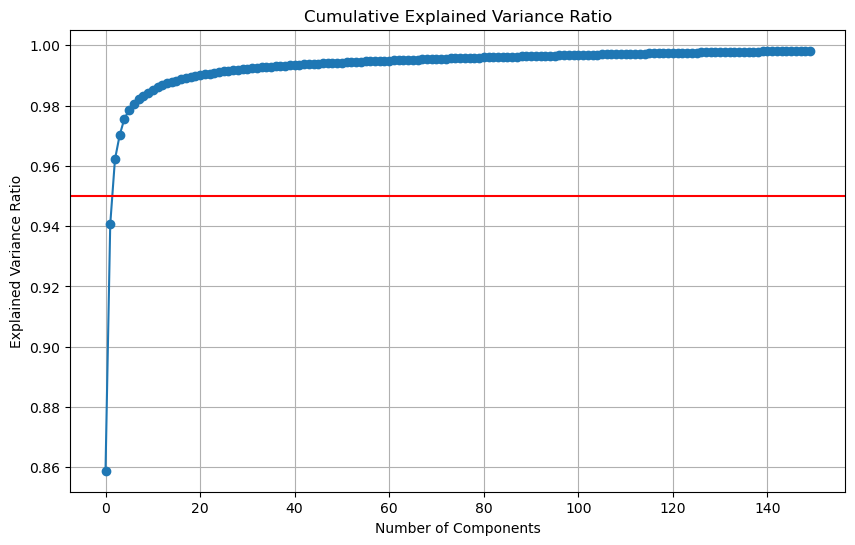

Number of components needed to explain 95% variance: 3
Top 5 principal components explain: 0.9757 of variance
Original FFT features shape: (11032, 1025)
PCA FFT features shape: (11032, 150)
Combined features shape: (11032, 246)
Test combined features shape: (2760, 246)


In [7]:
def apply_pca_to_fft(fft_features, test_features=None, n_components=100, plot=True):
    """
    Áp dụng PCA để giảm số chiều của đặc trưng FFT.
    
    Args:
        fft_features: Mảng đặc trưng FFT cho tập huấn luyện
        test_features: Mảng đặc trưng FFT cho tập kiểm tra (nếu có)
        n_components: Số lượng thành phần chính muốn giữ lại
        plot: Vẽ đồ thị tỷ lệ phương sai giải thích được
        
    Returns:
        fft_pca: Đặc trưng FFT sau khi áp dụng PCA cho tập huấn luyện
        test_pca: Đặc trưng FFT sau khi áp dụng PCA cho tập kiểm tra (nếu có)
        pca: Đối tượng PCA đã được huấn luyện
    """
    from sklearn.decomposition import PCA
    
    # Khởi tạo và huấn luyện PCA
    pca = PCA(n_components=n_components, random_state=53940)
    fft_pca = pca.fit_transform(fft_features)
    
    # Áp dụng cho tập kiểm tra (nếu có)
    test_pca = None
    if test_features is not None:
        test_pca = pca.transform(test_features)
    
    # Vẽ đồ thị tỷ lệ phương sai giải thích được
    if plot:
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
        
        plt.figure(figsize=(10, 6))
        plt.plot(cumulative_variance_ratio, marker='o')
        plt.axhline(y=0.95, color='r', linestyle='-')
        plt.grid(True)
        plt.title('Cumulative Explained Variance Ratio')
        plt.xlabel('Number of Components')
        plt.ylabel('Explained Variance Ratio')
        plt.show()
        
        # Tìm số lượng thành phần cần thiết để giải thích 95% phương sai
        n_components_95 = np.where(cumulative_variance_ratio >= 0.95)[0][0] + 1
        print(f"Number of components needed to explain 95% variance: {n_components_95}")
        
        # Hiển thị top 5 thành phần chính quan trọng nhất
        print(f"Top 5 principal components explain: {np.sum(explained_variance_ratio[:5]):.4f} of variance")
    
    return fft_pca, test_pca, pca

# Áp dụng PCA cho FFT features
train_fft_pca, test_fft_pca, fft_pca = apply_pca_to_fft(
    train_fft, test_features=test_fft, n_components=150
)

print(f"Original FFT features shape: {train_fft.shape}")
print(f"PCA FFT features shape: {train_fft_pca.shape}")

train_features = np.hstack((train_fft_pca, train_cqt))
test_features = np.hstack((test_fft_pca, test_cqt))

print(f"Combined features shape: {train_features.shape}")
print(f"Test combined features shape: {test_features.shape}")

In [15]:
def filter_fft_by_frequency_bands(fft_features, sample_rate=22050, nfft=2048, 
                                 bands=[(20, 200), (200, 1000), (1000, 8000)]):
    """
    Lọc đặc trưng FFT theo các dải tần số định nghĩa trước.
    
    Args:
        fft_features: Mảng đặc trưng FFT
        sample_rate: Tần số lấy mẫu
        nfft: Số điểm FFT
        bands: Danh sách các dải tần số muốn giữ lại, dạng (tần số thấp, tần số cao)
        
    Returns:
        band_features: Đặc trưng FFT sau khi lọc theo dải tần số
    """
    # Tính tần số tương ứng với mỗi bin FFT
    freq_bins = np.fft.rfftfreq(nfft, d=1/sample_rate)
    
    # Khởi tạo mảng để lưu đặc trưng được lọc
    selected_indices = []
    
    # Chọn các bin tần số thuộc vào các dải đã định nghĩa
    for low_freq, high_freq in bands:
        indices = np.where((freq_bins >= low_freq) & (freq_bins <= high_freq))[0]
        selected_indices.extend(indices)
    
    selected_indices = np.array(selected_indices)
    selected_indices.sort()
    
    # Lọc đặc trưng
    if fft_features.ndim == 1:
        band_features = fft_features[selected_indices]
    else:
        band_features = fft_features[:, selected_indices]
    
    print(f"Selected {len(selected_indices)} frequency bins from bands {bands}")
    print(f"Frequency range: {freq_bins[selected_indices[0]]:.1f}Hz to {freq_bins[selected_indices[-1]]:.1f}Hz")
    
    return band_features, selected_indices

# Định nghĩa các dải tần số quan trọng cho âm thanh ong
# Có thể điều chỉnh dựa trên đặc điểm sinh học của âm thanh ong
important_bands = [
    (50, 300),    # Tần số thấp của âm thanh ong (bzzzz)
    (300, 1500),  # Tần số trung bình
    (1500, 5000)  # Tần số cao (có thể chứa thông tin phân biệt)
]

# Lọc đặc trưng FFT theo dải tần số
train_fft_bands, band_indices = filter_fft_by_frequency_bands(
    train_fft, sample_rate=22050, nfft=2048, bands=important_bands
)

# Áp dụng cùng bộ lọc cho dữ liệu test
if test_fft.ndim == 1:
    test_fft_bands = test_fft[band_indices]
else:
    test_fft_bands = test_fft[:, band_indices]

print(f"Original FFT features shape: {train_fft.shape}")
print(f"Filtered FFT features shape: {train_fft_bands.shape}")

train_features = np.hstack((train_fft_bands, train_cqt))
test_features = np.hstack((test_fft_bands, test_cqt))

print(f"Combined features shape: {train_features.shape}")
print(f"Test combined features shape: {test_features.shape}")

Selected 460 frequency bins from bands [(50, 300), (300, 1500), (1500, 5000)]
Frequency range: 53.8Hz to 4995.7Hz
Original FFT features shape: (11032, 1025)
Filtered FFT features shape: (11032, 460)
Combined features shape: (11032, 556)
Test combined features shape: (2760, 556)


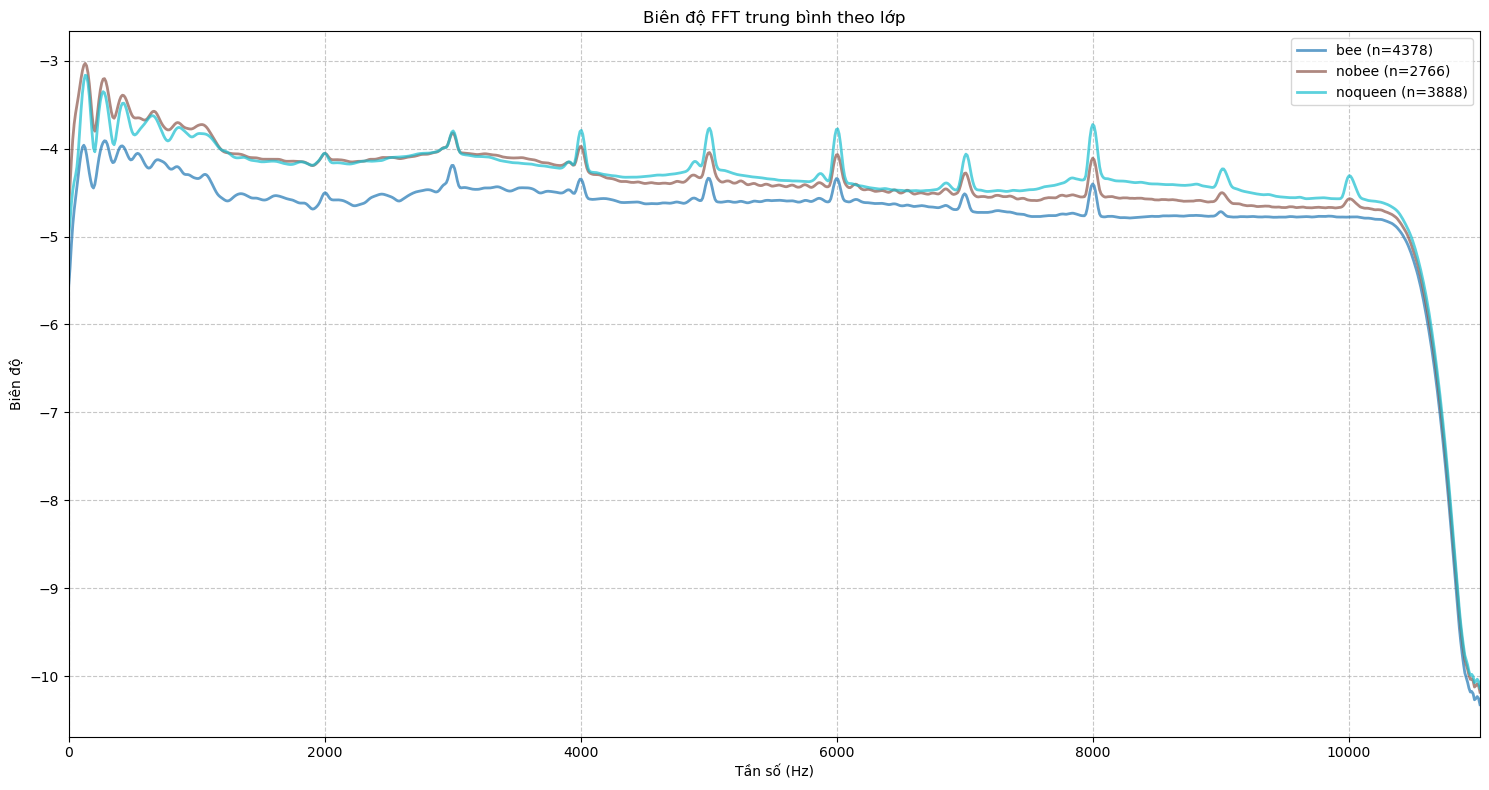

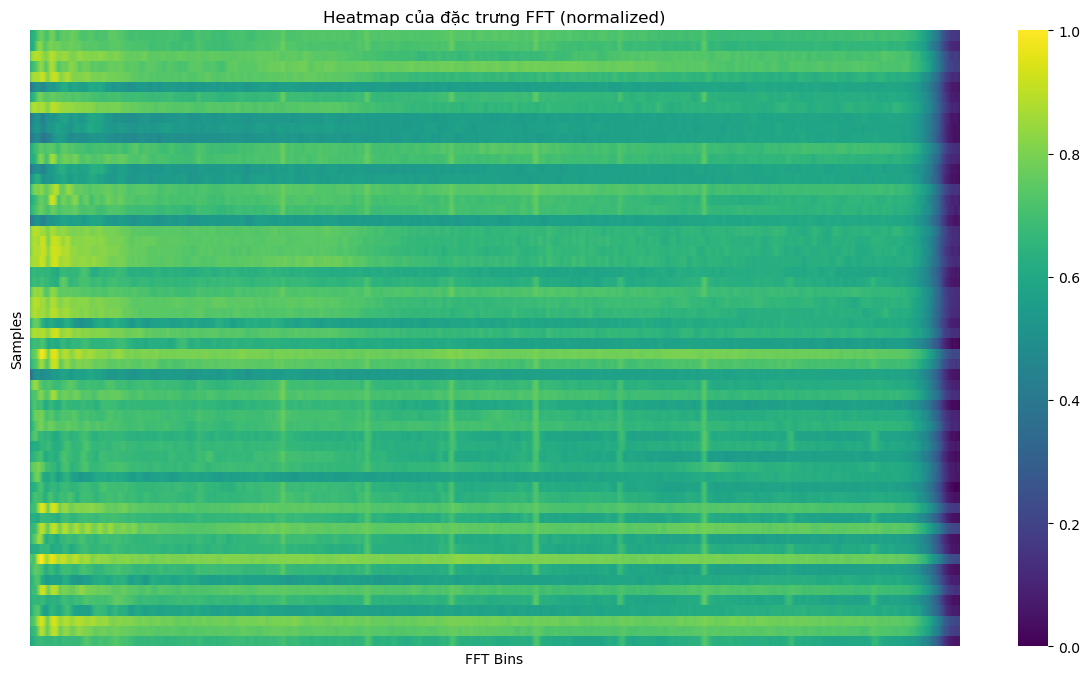

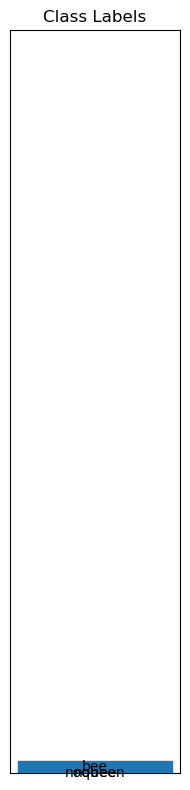

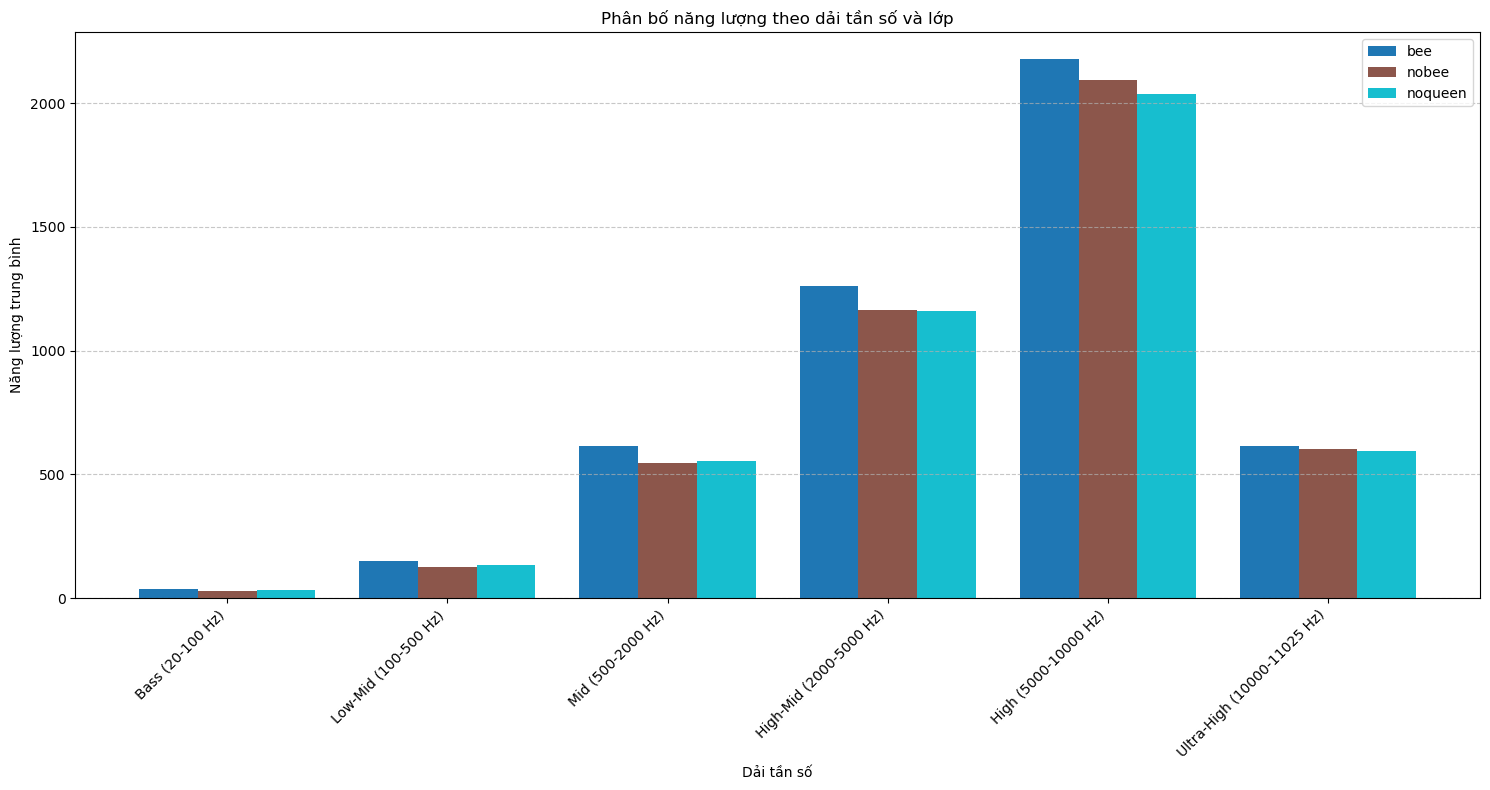

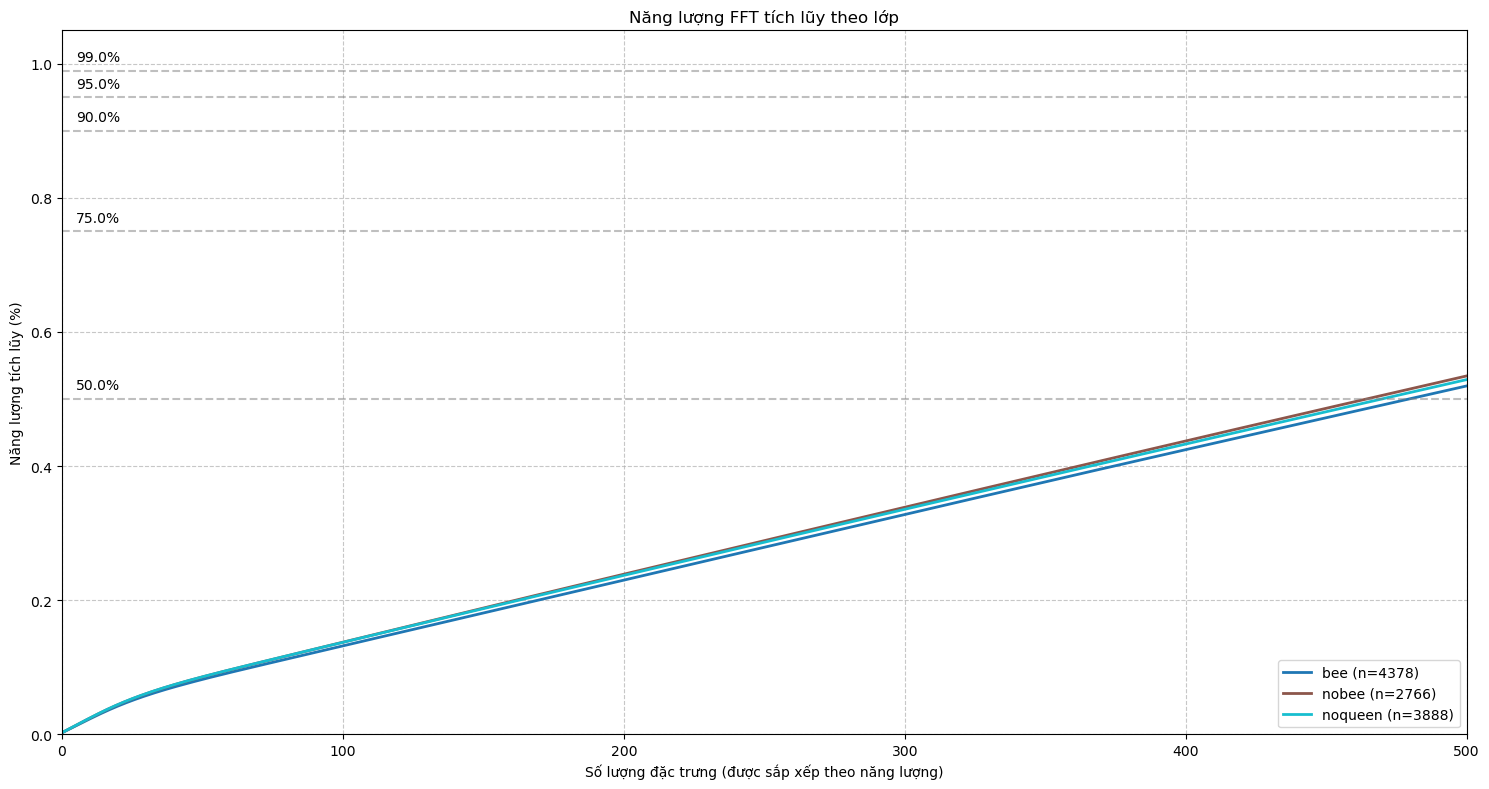

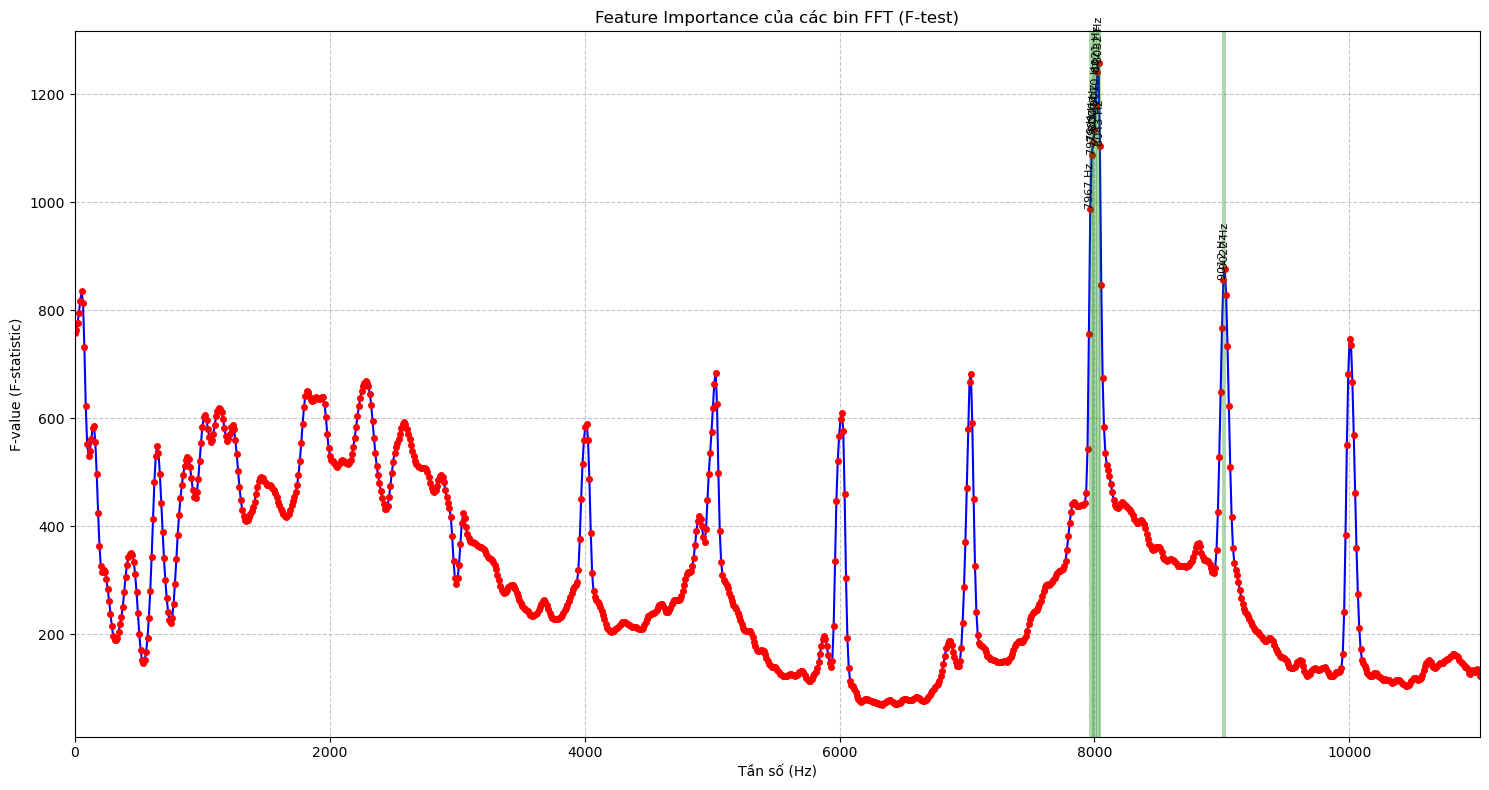

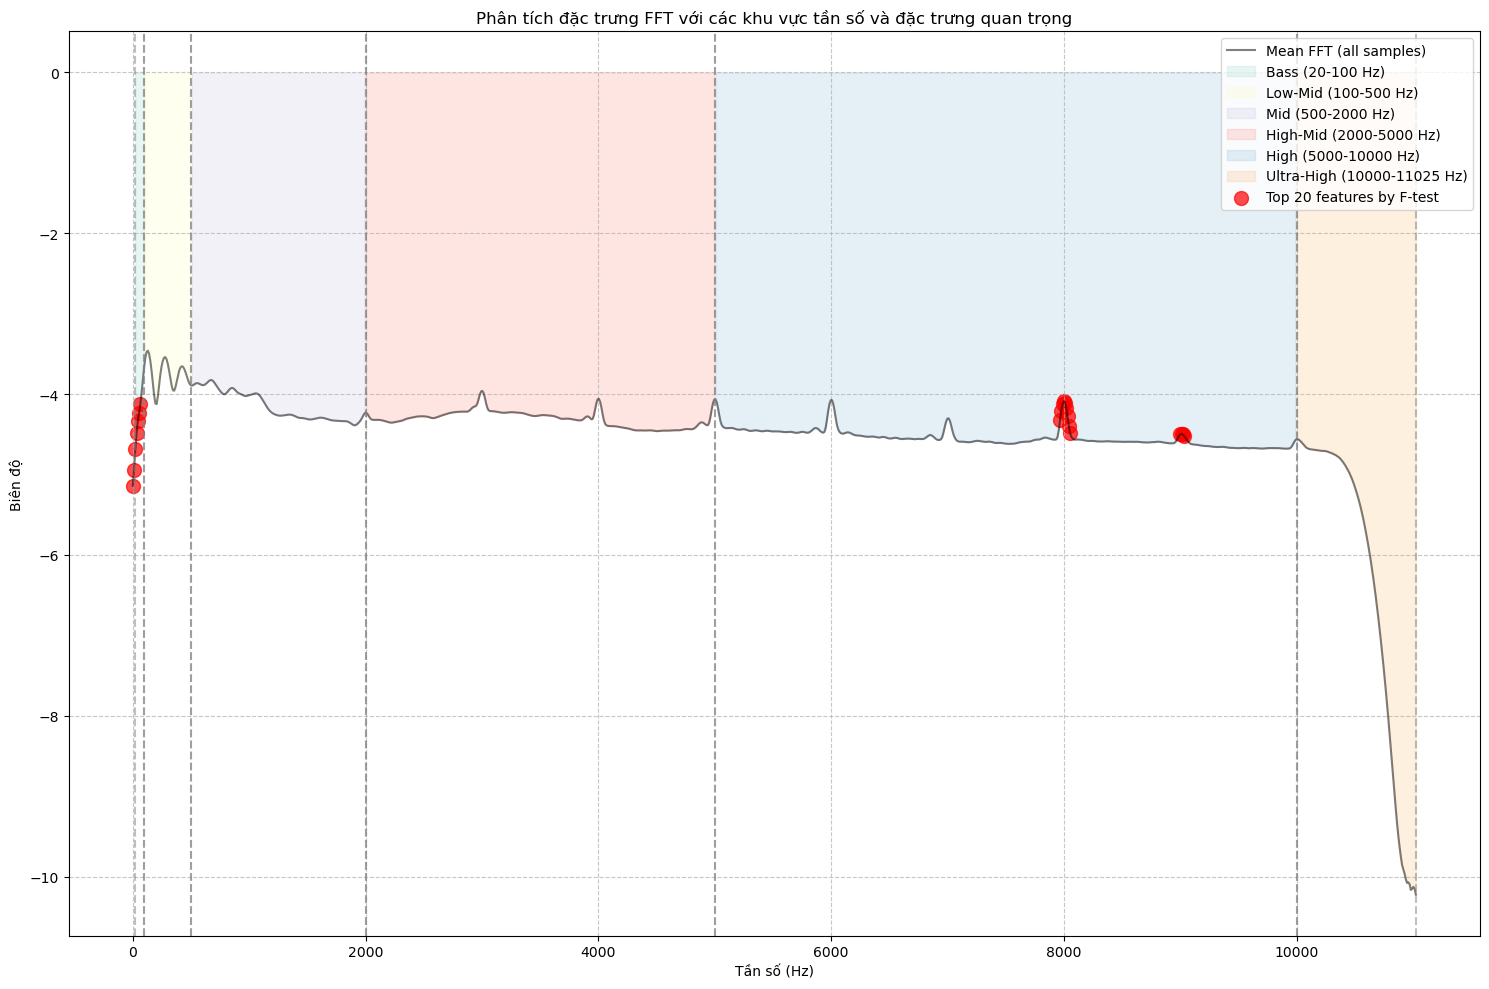

Đã lọc 200 đặc trưng sử dụng F-test
Đã lọc 839 đặc trưng từ 3 dải tần số: High (5000-10000 Hz), High-Mid (2000-5000 Hz), Ultra-High (10000-11025 Hz)
Đã lọc 200 đặc trưng sử dụng ngưỡng năng lượng tích lũy 0.95

Kết quả lọc đặc trưng FFT:
Ban đầu: (11032, 1025)
F-test: (11032, 200)
Dải tần số: (11032, 839)
Năng lượng tích lũy: (11032, 200)


In [10]:
def plot_fft_features_with_filters(fft_features, labels, sample_rate=22050, nfft=2048):
    """
    Trực quan hóa đặc trưng FFT và các tùy chọn lọc khác nhau.
    
    Args:
        fft_features: Mảng đặc trưng FFT (n_samples, n_features)
        labels: Nhãn tương ứng
        sample_rate: Tần số lấy mẫu
        nfft: Số điểm FFT
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.preprocessing import LabelEncoder
    import numpy as np
    
    # Kiểm tra dữ liệu để tránh lỗi log-scaling
    # Nếu dữ liệu có giá trị nhỏ hơn hoặc bằng 0, thêm một hằng số nhỏ
    epsilon = 1e-10
    if np.any(fft_features <= 0):
        print(f"Warning: Data contains non-positive values. Adding {epsilon} to avoid log-scaling issues.")
        fft_features = fft_features + epsilon
    
    # Chuyển đổi nhãn sang dạng số nếu cần
    if labels.dtype == object:
        le = LabelEncoder()
        labels_encoded = le.fit_transform(labels)
        label_names = le.classes_
    else:
        labels_encoded = labels
        label_names = np.unique(labels)
    
    # Tính tần số tương ứng với mỗi bin FFT
    freq_bins = np.fft.rfftfreq(nfft, d=1/sample_rate)
    
    # Tạo colormap để hiển thị các lớp
    colors = plt.cm.tab10(np.linspace(0, 1, len(np.unique(labels_encoded))))
    
    # 1. Plot trung bình FFT cho mỗi lớp
    plt.figure(figsize=(15, 8))
    
    for i, label in enumerate(np.unique(labels_encoded)):
        # Lấy tất cả mẫu thuộc lớp này
        class_samples = fft_features[labels_encoded == label]
        # Tính trung bình
        mean_fft = np.mean(class_samples, axis=0)
        # Plot trên thang logarithmic (sử dụng semilogy chỉ khi dữ liệu toàn dương)
        if np.all(mean_fft > 0):
            plt.semilogy(freq_bins, mean_fft, 
                        label=f'{label_names[i]} (n={len(class_samples)})',
                        color=colors[i], alpha=0.7, linewidth=2)
        else:
            # Nếu có giá trị âm, dùng plot thông thường
            plt.plot(freq_bins, mean_fft, 
                    label=f'{label_names[i]} (n={len(class_samples)})',
                    color=colors[i], alpha=0.7, linewidth=2)
    
    plt.xlabel('Tần số (Hz)')
    plt.ylabel('Biên độ')
    plt.title('Biên độ FFT trung bình theo lớp')
    plt.grid(True, ls="--", alpha=0.7)
    plt.legend()
    plt.xlim(0, sample_rate/2)  # Hiển thị tối đa đến Nyquist frequency
    plt.tight_layout()
    plt.show()
    
    # 2. Plot heatmap của đặc trưng FFT
    plt.figure(figsize=(15, 8))
    
    # Lấy mẫu ngẫu nhiên cho mỗi lớp để hiển thị (tối đa 20 mẫu mỗi lớp)
    n_samples_per_class = 20
    sample_indices = []
    for label in np.unique(labels_encoded):
        class_indices = np.where(labels_encoded == label)[0]
        if len(class_indices) > n_samples_per_class:
            sample_indices.extend(np.random.choice(class_indices, n_samples_per_class, replace=False))
        else:
            sample_indices.extend(class_indices)
    
    # Sắp xếp theo nhãn để hiển thị rõ ràng hơn
    sample_indices = np.array(sample_indices)
    sorted_indices = np.argsort(labels_encoded[sample_indices])
    sample_indices = sample_indices[sorted_indices]
    
    # Chuẩn hóa dữ liệu để hiển thị tốt hơn
    # Thay vì log transform, dùng min-max scaling để tránh NaN
    plot_data = fft_features[sample_indices]
    vmin = np.min(plot_data)
    vmax = np.max(plot_data)
    if vmin != vmax:  # Tránh chia cho 0
        plot_data = (plot_data - vmin) / (vmax - vmin)
    
    # Tạo heatmap
    sns.heatmap(plot_data, cmap='viridis', 
               xticklabels=False, yticklabels=False)
    plt.xlabel('FFT Bins')
    plt.ylabel('Samples')
    plt.title('Heatmap của đặc trưng FFT (normalized)')
    
    # Thêm thanh màu bên phải để hiển thị lớp - sử dụng axes riêng
    plt.figure(figsize=(2, 8))
    ax_side = plt.gca()
    for i, label in enumerate(np.unique(labels_encoded)):
        class_mask = labels_encoded[sample_indices] == label
        ax_side.fill_between([0, 1], 
                           [sum(class_mask[:i]), sum(class_mask[:i])], 
                           [sum(class_mask[:i+1]), sum(class_mask[:i+1])], 
                           color=colors[i])
        # Thêm nhãn lớp
        y_pos = sum(class_mask[:i]) + sum(class_mask[:i+1]) / 2
        ax_side.text(0.5, y_pos, label_names[i], ha='center', va='center')
    
    ax_side.set_ylim(0, len(sample_indices))
    ax_side.set_xticks([])
    ax_side.set_yticks([])
    plt.title('Class Labels')
    plt.tight_layout()
    plt.show()
    
    # 3. Trực quan hóa phân phối năng lượng theo dải tần số
    plt.figure(figsize=(15, 8))
    
    # Định nghĩa các dải tần số để phân tích
    freq_bands = [
        (20, 100, "Bass (20-100 Hz)"),
        (100, 500, "Low-Mid (100-500 Hz)"),
        (500, 2000, "Mid (500-2000 Hz)"),
        (2000, 5000, "High-Mid (2000-5000 Hz)"),
        (5000, 10000, "High (5000-10000 Hz)"),
        (10000, sample_rate/2, f"Ultra-High (10000-{int(sample_rate/2)} Hz)")
    ]
    
    # Tính năng lượng của từng dải tần số cho mỗi lớp
    band_energies = []
    for low, high, name in freq_bands:
        # Tìm các bin FFT thuộc dải tần số này
        bin_mask = (freq_bins >= low) & (freq_bins <= high)
        
        # Tính năng lượng trung bình trong dải cho mỗi lớp
        band_energy = []
        for i, label in enumerate(np.unique(labels_encoded)):
            class_samples = fft_features[labels_encoded == label]
            # Tính giá trị tuyệt đối trước khi tính tổng để đảm bảo năng lượng luôn dương
            mean_energy = np.mean(np.sum(np.abs(class_samples[:, bin_mask]), axis=1))
            band_energy.append(mean_energy)
        
        band_energies.append(band_energy)
    
    # Chuyển sang định dạng array
    band_energies = np.array(band_energies)
    
    # Plot năng lượng theo dải tần số
    band_names = [name for low, high, name in freq_bands]
    
    # Vẽ biểu đồ cột
    x = np.arange(len(band_names))
    width = 0.8 / len(np.unique(labels_encoded))
    
    for i, label in enumerate(np.unique(labels_encoded)):
        plt.bar(x + i*width - 0.4 + width/2, band_energies[:, i], 
               width=width, label=f'{label_names[i]}', color=colors[i])
    
    plt.xlabel('Dải tần số')
    plt.ylabel('Năng lượng trung bình')
    plt.title('Phân bố năng lượng theo dải tần số và lớp')
    plt.xticks(x, band_names, rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # 4. Plot phân phối năng lượng tích lũy
    plt.figure(figsize=(15, 8))
    
    for i, label in enumerate(np.unique(labels_encoded)):
        # Lấy tất cả mẫu thuộc lớp này
        class_samples = fft_features[labels_encoded == label]
        # Tính trung bình
        mean_fft = np.mean(class_samples, axis=0)
        # Sử dụng giá trị tuyệt đối để đảm bảo năng lượng luôn dương
        abs_mean_fft = np.abs(mean_fft)
        # Sắp xếp theo thứ tự giảm dần
        sorted_indices = np.argsort(abs_mean_fft)[::-1]
        # Tính năng lượng tích lũy
        cumulative_energy = np.cumsum(abs_mean_fft[sorted_indices]) / np.sum(abs_mean_fft)
        
        plt.plot(range(len(cumulative_energy)), cumulative_energy, 
                label=f'{label_names[i]} (n={len(class_samples)})',
                color=colors[i], linewidth=2)
    
    # Đánh dấu các ngưỡng năng lượng
    thresholds = [0.5, 0.75, 0.9, 0.95, 0.99]
    for threshold in thresholds:
        plt.axhline(y=threshold, linestyle='--', color='gray', alpha=0.5)
        plt.text(5, threshold+0.01, f'{threshold*100}%', va='bottom')
    
    plt.xlabel('Số lượng đặc trưng (được sắp xếp theo năng lượng)')
    plt.ylabel('Năng lượng tích lũy (%)')
    plt.title('Năng lượng FFT tích lũy theo lớp')
    plt.grid(True, ls="--", alpha=0.7)
    plt.legend()
    plt.xlim(0, min(500, len(freq_bins)))  # Chỉ hiển thị 500 đặc trưng đầu tiên
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()
    
    # 5. Feature Importance với F-statistic
    from sklearn.feature_selection import f_classif
    
    plt.figure(figsize=(15, 8))
    
    # Tính F-statistic cho mỗi bin FFT
    f_values, p_values = f_classif(fft_features, labels_encoded)
    
    # Plot F-values
    plt.plot(freq_bins, f_values, 'b-', linewidth=1.5)
    
    # Highlight các bin có p-value nhỏ (có ý nghĩa thống kê)
    significant = p_values < 0.01
    if np.any(significant):
        plt.plot(freq_bins[significant], f_values[significant], 'r.', markersize=8)
    
    plt.xlabel('Tần số (Hz)')
    plt.ylabel('F-value (F-statistic)')
    plt.title('Feature Importance của các bin FFT (F-test)')
    plt.grid(True, ls="--", alpha=0.7)
    plt.xlim(0, sample_rate/2)
    
    # Highlight top 10 bins có F-value cao nhất
    top_indices = np.argsort(f_values)[-10:]
    for idx in top_indices:
        plt.axvline(x=freq_bins[idx], color='g', alpha=0.3)
        plt.text(freq_bins[idx], f_values[idx], f'{freq_bins[idx]:.0f} Hz', 
                rotation=90, va='bottom', ha='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # 6. Plot để hiển thị các dải tần số và đặc trưng quan trọng
    plt.figure(figsize=(15, 10))

    # Plot mean FFT across all samples
    mean_fft_all = np.mean(fft_features, axis=0) if fft_features.ndim > 1 else fft_features
    
    # Sử dụng plot thông thường thay vì semilogy
    plt.plot(freq_bins, mean_fft_all, 'k-', alpha=0.5, label='Mean FFT (all samples)')

    # Highlight regions based on frequency bands
    freq_band_colors = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3', '#fdb462']
    for i, (low, high, name) in enumerate(freq_bands):
        band_indices = np.where((freq_bins >= low) & (freq_bins <= high))[0]
        if len(band_indices) > 0:
            plt.fill_between(freq_bins[band_indices], 
                            np.zeros_like(mean_fft_all[band_indices]), 
                            mean_fft_all[band_indices],
                            color=freq_band_colors[i % len(freq_band_colors)], 
                            alpha=0.2, 
                            label=name)
            # Add vertical lines at band boundaries
            plt.axvline(x=low, color='gray', linestyle='--', alpha=0.5)
            plt.axvline(x=high, color='gray', linestyle='--', alpha=0.5)

    # Highlight top features by F-test
    top_k = 20  # Số lượng đặc trưng quan trọng nhất để highlight
    top_indices = np.argsort(f_values)[-top_k:]
    plt.scatter(freq_bins[top_indices], mean_fft_all[top_indices], 
               color='red', marker='o', s=100, alpha=0.7, 
               label=f'Top {top_k} features by F-test')

    plt.xlabel('Tần số (Hz)')
    plt.ylabel('Biên độ')
    plt.title('Phân tích đặc trưng FFT với các khu vực tần số và đặc trưng quan trọng')
    plt.grid(True, ls="--", alpha=0.7)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    
    # Trả về các kết quả có thể được sử dụng để lọc đặc trưng
    return {
        'freq_bins': freq_bins,
        'f_values': f_values,
        'p_values': p_values,
        'top_f_indices': np.argsort(f_values)[-100:],  # Top 100 features by F-test
        'band_energies': band_energies,
        'freq_bands': freq_bands
    }

# Vẽ và phân tích đặc trưng FFT
filter_results = plot_fft_features_with_filters(train_fft, train_labels, sample_rate=22050, nfft=2048)

# Hàm để lọc đặc trưng FFT dựa trên kết quả phân tích
def filter_fft_features(fft_features, filter_results, method='f_test', n_features=200):
    """
    Lọc đặc trưng FFT dựa trên các kết quả phân tích.
    
    Args:
        fft_features: Mảng đặc trưng FFT
        filter_results: Kết quả từ hàm plot_fft_features_with_filters
        method: Phương pháp lọc ('f_test', 'freq_bands', 'cumulative_energy')
        n_features: Số lượng đặc trưng muốn giữ lại (chỉ dùng với 'f_test' và 'cumulative_energy')
        
    Returns:
        filtered_features: Đặc trưng FFT sau khi lọc
        selected_indices: Chỉ số của các đặc trưng được chọn
    """
    # Khởi tạo biến để tránh UnboundLocalError
    filtered_features = None
    selected_indices = None
    
    if method == 'f_test':
        # Lọc theo F-test
        selected_indices = np.argsort(filter_results['f_values'])[-n_features:]
        if fft_features.ndim == 1:
            filtered_features = fft_features[selected_indices]
        else:
            filtered_features = fft_features[:, selected_indices]
        print(f"Đã lọc {n_features} đặc trưng sử dụng F-test")
        
    elif method == 'freq_bands':
        # Lọc theo dải tần số có năng lượng cao
        freq_bins = filter_results['freq_bins']
        band_energies = filter_results['band_energies']
        freq_bands = filter_results['freq_bands']
        
        # Tìm dải tần số có năng lượng cao nhất
        band_total_energy = np.sum(band_energies, axis=1)
        sorted_bands = np.argsort(band_total_energy)[::-1]
        
        # Lấy 3 dải tần số có năng lượng cao nhất
        selected_bands = [freq_bands[i] for i in sorted_bands[:3]]
        selected_indices = []
        
        for low, high, name in selected_bands:
            # Tìm các bin FFT thuộc dải tần số này
            bin_indices = np.where((freq_bins >= low) & (freq_bins <= high))[0]
            selected_indices.extend(bin_indices)
        
        selected_indices = np.array(selected_indices)
        selected_indices.sort()
        
        if fft_features.ndim == 1:
            filtered_features = fft_features[selected_indices]
        else:
            filtered_features = fft_features[:, selected_indices]
            
        print(f"Đã lọc {len(selected_indices)} đặc trưng từ 3 dải tần số: " + 
             ", ".join([name for _, _, name in selected_bands]))
        
    elif method == 'cumulative_energy':
        # Sử dụng energy threshold để chọn đặc trưng quan trọng
        mean_fft = np.mean(fft_features, axis=0) if fft_features.ndim > 1 else fft_features
        sorted_indices = np.argsort(mean_fft)[::-1]
        
        # Tính năng lượng tích lũy
        cumulative_energy = np.cumsum(mean_fft[sorted_indices]) / np.sum(mean_fft)
        # Tìm số lượng đặc trưng để đạt được 95% năng lượng
        energy_threshold = 0.95
        n_features_energy = np.where(cumulative_energy >= energy_threshold)[0][0] + 1
        
        # Lấy số lượng đặc trưng đó (hoặc n_features, lấy số nhỏ hơn)
        n_select = min(n_features_energy, n_features)
        selected_indices = sorted_indices[:n_select]
        
        if fft_features.ndim == 1:
            filtered_features = fft_features[selected_indices]
        else:
            filtered_features = fft_features[:, selected_indices]
            
        print(f"Đã lọc {n_select} đặc trưng sử dụng ngưỡng năng lượng tích lũy {energy_threshold:.2f}")
        
    else:
        raise ValueError("Phương pháp không hợp lệ. Hỗ trợ: 'f_test', 'freq_bands', 'cumulative_energy'")
    
    # Kiểm tra xem biến đã được gán chưa
    if filtered_features is None or selected_indices is None:
        raise ValueError(f"Lỗi trong quá trình lọc đặc trưng với phương pháp '{method}'")
    
    return filtered_features, selected_indices

# Ví dụ sử dụng từng phương pháp lọc
train_fft_f_test, f_test_indices = filter_fft_features(train_fft, filter_results, method='f_test', n_features=200)
train_fft_bands, band_indices = filter_fft_features(train_fft, filter_results, method='freq_bands')
train_fft_energy, energy_indices = filter_fft_features(train_fft, filter_results, method='cumulative_energy', n_features=200)

# Áp dụng các bộ lọc cho dữ liệu test
test_fft_f_test = test_fft[:, f_test_indices]
test_fft_bands = test_fft[:, band_indices]  
test_fft_energy = test_fft[:, energy_indices]

# Hiển thị kích thước các đặc trưng đã lọc
print(f"\nKết quả lọc đặc trưng FFT:")
print(f"Ban đầu: {train_fft.shape}")
print(f"F-test: {train_fft_f_test.shape}")
print(f"Dải tần số: {train_fft_bands.shape}")
print(f"Năng lượng tích lũy: {train_fft_energy.shape}")

In [30]:
train_features.shape

(11032, 1121)

In [31]:
train_features.dtype

dtype('float64')

In [32]:
scaler_cqt = StandardScaler()
train_features_scaled = scaler_cqt.fit_transform(train_features)
test_features_scaled  = scaler_cqt.transform(test_features)

In [33]:
start_time = time.time()

knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_features, train_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_accuracy_knn = knn_classifier.predict(test_features)
print(f"KNN (FFT features) - Test Accuracy: {accuracy_score(test_labels, test_accuracy_knn)*100:.2f}%")

Training time: 0.03 seconds
KNN (FFT features) - Test Accuracy: 86.52%


In [34]:
start_time = time.time()

knn_classifier_cqt = KNeighborsClassifier(n_neighbors=1, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
                                      metric='minkowski', metric_params=None, n_jobs=None)

knn_classifier_cqt.fit(train_features_scaled, train_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_pred_cqt_knn = knn_classifier_cqt.predict(test_features_scaled)

test_accuracy_cqt_knn = accuracy_score(test_labels, test_pred_cqt_knn)
print(f"KNN (CQT) - Test Accuracy: {test_accuracy_cqt_knn*100:.2f}%")


Training time: 0.03 seconds
KNN (CQT) - Test Accuracy: 85.72%


53940 with Accuracy: 89.60%



In [14]:
start_time = time.time()

svm_rbf_classifier = SVC(C=71.19418600172986, kernel='rbf', degree=3, gamma=0.03752055855124281, 
                         coef0=0.0, shrinking=True, probability=False, tol=0.0005319450186421158, 
                         cache_size=500, class_weight=None, verbose=False, max_iter=-1, 
                         decision_function_shape='ovr', break_ties=False, random_state=42)


# Huấn luyện mô hình SVM trên dữ liệu kết hợp
svm_rbf_classifier.fit(train_features, train_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_svm_rbf = svm_rbf_classifier.predict(test_features)
test_accuracy_svm = accuracy_score(test_labels, test_predictions_svm_rbf)
print(f"Test Accuracy (SVM with RBF Kernel): {test_accuracy_svm * 100:.2f}%")

Training time: 11.99 seconds
Test Accuracy (SVM with RBF Kernel): 89.60%


1. Feature Selection with Statistical Methods 87.32%

2.1 Principal Component Analysis (PCA) 100 features 89.20%

2.2 Principal Component Analysis (PCA) 200 features 89.35%

2.2 Principal Component Analysis (PCA) 150 features 89.60%

3. Lọc theo dải tần số có ý nghĩa 88.80%

In [36]:
start_time = time.time()

svm_rbf_classifier = SVC(C=71.19418600172986, kernel='rbf', degree=3, gamma=0.03752055855124281, 
                         coef0=0.0, shrinking=True, probability=False, tol=0.0005319450186421158, 
                         cache_size=500, class_weight=None, verbose=False, max_iter=-1, 
                         decision_function_shape='ovr', break_ties=False, random_state=42)

# Huấn luyện mô hình SVM
svm_rbf_classifier.fit(train_features_scaled, train_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_svm_rbf = svm_rbf_classifier.predict(test_features_scaled)
scale_test_accuracy_svm = accuracy_score(test_labels, test_predictions_svm_rbf)
print(f"Test Accuracy (SVM with RBF Kernel): {scale_test_accuracy_svm * 100:.2f}%")

Training time: 102.05 seconds
Test Accuracy (SVM with RBF Kernel): 88.66%


In [37]:
start_time = time.time()

lr_classifier = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True, intercept_scaling=1, 
                                   class_weight=None, random_state=42, solver='lbfgs', max_iter=1500, multi_class='deprecated', 
                                   verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
lr_classifier.fit(train_features, train_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_accuracy_lr = lr_classifier.predict(test_features)
print(f"Logistic Regression (FFT features) - Test Accuracy: {accuracy_score(test_labels, test_accuracy_lr)*100:.2f}%")

Training time: 19.84 seconds
Logistic Regression (FFT features) - Test Accuracy: 78.66%


c:\Users\dinhg\anaconda3\envs\AI\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [38]:
start_time = time.time()

lr_classifier = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True, intercept_scaling=1, 
                                   class_weight=None, random_state=42, solver='saga', max_iter=1000, multi_class='deprecated', 
                                   verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

lr_classifier.fit(train_features_scaled, train_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

scale_test_accuracy_lr = lr_classifier.predict(test_features_scaled)
print(f"Logistic Regression (FFT features) - Test Accuracy: {accuracy_score(test_labels, scale_test_accuracy_lr)*100:.2f}%")

Training time: 358.40 seconds
Logistic Regression (FFT features) - Test Accuracy: 78.44%


c:\Users\dinhg\anaconda3\envs\AI\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [39]:
start_time = time.time()

rf_classifier = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                                       min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', 
                                       max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, 
                                       n_jobs=None, random_state=42, verbose=0, warm_start=False, class_weight=None, 
                                       ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

rf_classifier.fit(train_features, train_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_accuracy_rf = rf_classifier.predict(test_features)
print(f"Random Forest (FFT features) - Test Accuracy: {accuracy_score(test_labels, test_accuracy_rf)*100:.2f}%")

Training time: 60.62 seconds
Random Forest (FFT features) - Test Accuracy: 85.47%


In [40]:
start_time = time.time()

et_classifier = ExtraTreesClassifier(n_estimators=200, criterion='gini', max_depth=30, min_samples_split=2, min_samples_leaf=1, 
                                     min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                     bootstrap=False, oob_score=False, n_jobs=None, random_state=42, verbose=0, warm_start=False, 
                                     class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

et_classifier.fit(train_features, train_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_et = et_classifier.predict(test_features)
test_accuracy_et = accuracy_score(test_labels, test_predictions_et)
print(f"Test Accuracy (Extra Trees): {test_accuracy_et * 100:.2f}%")

Training time: 546.25 seconds
Test Accuracy (Extra Trees): 87.14%


In [41]:
start_time = time.time()

et_classifier = ExtraTreesClassifier(n_estimators=200, criterion='gini', max_depth=30, min_samples_split=2, min_samples_leaf=1, 
                                     min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                     bootstrap=False, oob_score=False, n_jobs=None, random_state=42, verbose=0, warm_start=False, 
                                     class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

# Huấn luyện mô hình Extra Trees với dữ liệu đã chuẩn hóa
et_classifier.fit(train_features_scaled, train_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_et = et_classifier.predict(test_features_scaled)
scale_test_accuracy_et = accuracy_score(test_labels, test_predictions_et)
print(f"Test Accuracy (Extra Trees): {scale_test_accuracy_et * 100:.2f}%")



Training time: 548.03 seconds
Test Accuracy (Extra Trees): 87.14%


In [42]:
from sklearn.ensemble import GradientBoostingClassifier

start_time = time.time()

gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, 
                            max_depth=3, min_samples_split=2,
                            min_samples_leaf=1, subsample=1.0,
                            max_features='sqrt', random_state=42)

gb_classifier.fit(train_features_scaled, train_labels)

end_time = time.time()
print(f"Training time (Gradient Boosting): {end_time - start_time:.2f} seconds")

test_predictions_gb = gb_classifier.predict(test_features_scaled)
test_accuracy_gb = accuracy_score(test_labels, test_predictions_gb)
print(f"Test Accuracy (Gradient Boosting): {test_accuracy_gb * 100:.2f}%")
print("-" * 50)

Training time (Gradient Boosting): 59.53 seconds
Test Accuracy (Gradient Boosting): 84.75%
--------------------------------------------------


In [43]:
from sklearn.preprocessing import LabelEncoder
import time
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Chuyển đổi các nhãn từ chuỗi sang số
le = LabelEncoder()
train_labels_enc = le.fit_transform(train_labels)
val_labels_enc = le.transform(val_labels)
test_labels_enc = le.transform(test_labels)

start_time = time.time()

xgb_classifier = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=30,
    random_state=42,
    use_label_encoder=False,    # Tắt cảnh báo về label encoder
    eval_metric='logloss'       # Chỉ định hàm mất mát
)
xgb_classifier.fit(train_features, train_labels_enc)

end_time = time.time()
print(f"Training time (XGBoost): {end_time - start_time:.2f} seconds")

# Đánh giá trên bộ testing
test_predictions_xgb = xgb_classifier.predict(test_features)
test_accuracy_xgb = accuracy_score(test_labels_enc, test_predictions_xgb)
print(f"Test Accuracy (XGBoost): {test_accuracy_xgb * 100:.2f}%")


c:\Users\dinhg\anaconda3\envs\AI\lib\site-packages\xgboost\core.py:158: UserWarning: [19:54:48] WARNING: D:\bld\xgboost-split_1738880170463\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training time (XGBoost): 195.05 seconds
Test Accuracy (XGBoost): 87.32%


In [44]:
import lightgbm as lgb
import time
from sklearn.metrics import accuracy_score

start_time = time.time()

lgbm_classifier = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=30,
    random_state=42
)
lgbm_classifier.fit(train_features, train_labels)

end_time = time.time()
print(f"\nTraining time (LightGBM): {end_time - start_time:.2f} seconds")

# Đánh giá trên bộ testing
test_predictions_lgbm = lgbm_classifier.predict(test_features)
test_accuracy_lgbm = accuracy_score(test_labels, test_predictions_lgbm)
print(f"Test Accuracy (LightGBM): {test_accuracy_lgbm * 100:.2f}%")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 285855
[LightGBM] [Info] Number of data points in the train set: 11032, number of used features: 1121
[LightGBM] [Info] Start training from score -0.924208
[LightGBM] [Info] Start training from score -1.383398
[LightGBM] [Info] Start training from score -1.042905

Training time (LightGBM): 15.58 seconds
Test Accuracy (LightGBM): 87.50%


c:\Users\dinhg\anaconda3\envs\AI\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
